# Modelling blood glucose levels 

## With data provided from Bio Conscious Technologies

### By: Sergei Issaev

## Importing the packages

In [1]:
#Import necessary libraries
import pandas as pd
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from pandas import concat
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts 
from sklearn.metrics import mean_squared_error
from arch import arch_model
from math import sqrt
import seaborn as sns
sns.set()

In [2]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Importing the data

The goal of this project is to accurately predict blood glucose levels in future time periods. Activity data and heart rate data are provided as exogenous variables to help with blood glucose level prediction.

In [3]:
#Blood glucose data
raw_bg_data = pd.read_csv('blood-glucose-data.csv')

In [4]:
#Activity data
raw_da_data = pd.read_csv('distance-activity-data.csv')

In [5]:
#Heart rate data
raw_hr_data = pd.read_csv('heart-rate-data.csv')

In [6]:
#Create copies of all dataframes
df_bg = raw_bg_data.copy()

In [7]:
df_da = raw_da_data.copy()

In [8]:
df_hr = raw_hr_data.copy()

## Examining the data

In [9]:
#Visual examination of first 5 elements of each dataframe
df_bg.head()

,point_value(mg/dL),point_timestamp,timezone_offset
0,142,2017-05-15 07:51:22,-700
1,140,2017-05-15 07:56:23,-700
2,138,2017-05-15 08:01:22,-700
3,136,2017-05-15 08:06:22,-700
4,130,2017-05-15 08:11:23,-700


In [10]:
df_da.head()

,point_value(kilometers),point_timestamp,timezone_offset,device
0,0.03607,2017-05-15 15:52:44,-700,iPhone
1,0.30443,2017-05-15 15:59:36,-700,iPhone
2,0.31764,2017-05-15 16:09:35,-700,iPhone
3,0.16387,2017-05-15 16:16:43,-700,iPhone
4,0.01675,2017-05-15 16:27:07,-700,iPhone


In [11]:
df_hr.head()

,point_value,point_timestamp,timezone_offset
0,98,2017-05-16 22:16:00,-700
1,104,2017-05-16 22:17:00,-700
2,110,2017-05-16 22:18:00,-700
3,112,2017-05-16 22:19:00,-700
4,97,2017-05-16 22:20:00,-700


In [12]:
#Visual examination of entire dataframes
#These are commented out because they display a huge dataframe of raw values. 
#df_bg

In [13]:
#df_da

In [14]:
#df_hr

In [15]:
#Summary statistics for each of the dataframes
df_bg.describe()

,point_value(mg/dL),timezone_offset
count,14702.000000,14702.0
mean,166.753503,-700.0
std,76.361778,0.0
min,39.000000,-700.0
25%,109.000000,-700.0
50%,151.000000,-700.0
75%,210.000000,-700.0
max,401.000000,-700.0


In [16]:
df_da.describe()

,point_value(kilometers),timezone_offset
count,84920.000000,84920.0
mean,0.002107,-700.0
std,0.017215,0.0
min,0.000000,-700.0
25%,0.000000,-700.0
50%,0.000000,-700.0
75%,0.000000,-700.0
max,0.747830,-700.0


In [17]:
df_hr.describe()

,point_value,timezone_offset
count,69851.000000,69851.0
mean,88.122590,-700.0
std,16.481946,0.0
min,56.000000,-700.0
25%,75.000000,-700.0
50%,85.000000,-700.0
75%,100.000000,-700.0
max,202.000000,-700.0


In [18]:
#Checking for the presence of any "NaN"
#These are commented out, as they display the entire dataframe
#df_bg.isna()

In [19]:
#df_da.isna()

In [20]:
#df_hr.isna()

In [21]:
#Counting total number of "NaN" in all dataframes.
df_bg.isna().sum()

point_value(mg/dL)    0
point_timestamp       0
timezone_offset       0
dtype: int64

In [22]:
df_da.isna().sum()

point_value(kilometers)    0
point_timestamp            0
timezone_offset            0
device                     0
dtype: int64

In [23]:
df_hr.isna().sum()

point_value        0
point_timestamp    0
timezone_offset    0
dtype: int64

Conclusion: There are no "NaN" values in our dataframes

## Plotting the data

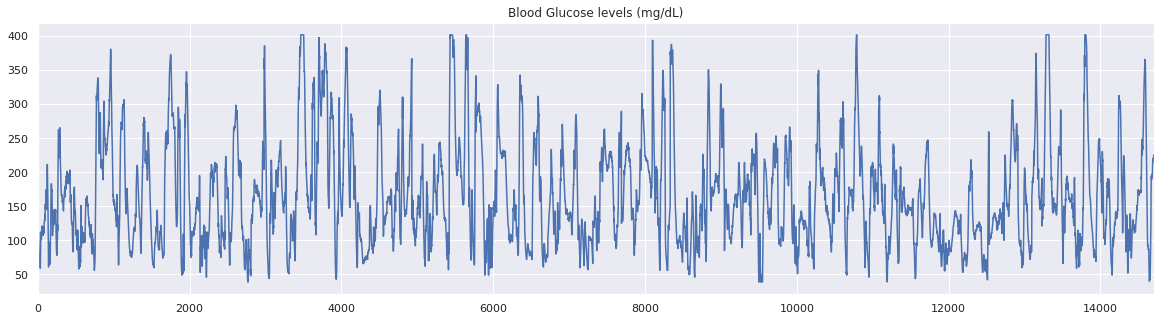

In [24]:
#Visualization of blood glucose level data
df_bg['point_value(mg/dL)'].plot(figsize = (20, 5), title = "Blood Glucose levels (mg/dL)")
plt.show()

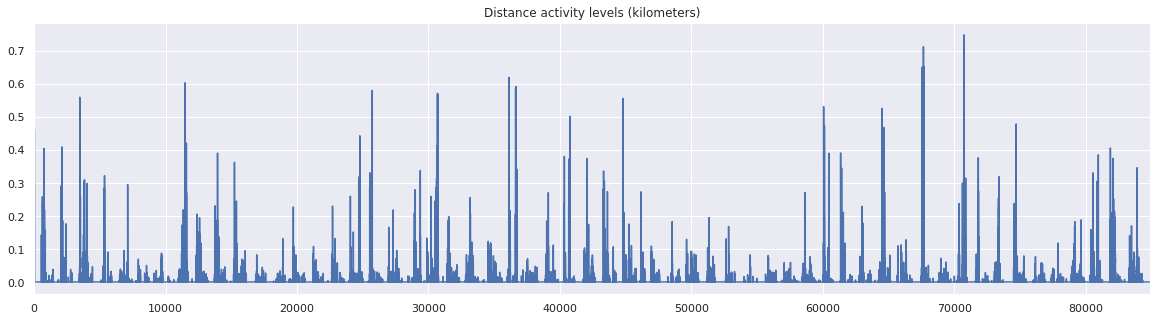

In [25]:
#Visualization of activity level level data
df_da['point_value(kilometers)'].plot(figsize = (20, 5), title = "Distance activity levels (kilometers)")
plt.show()

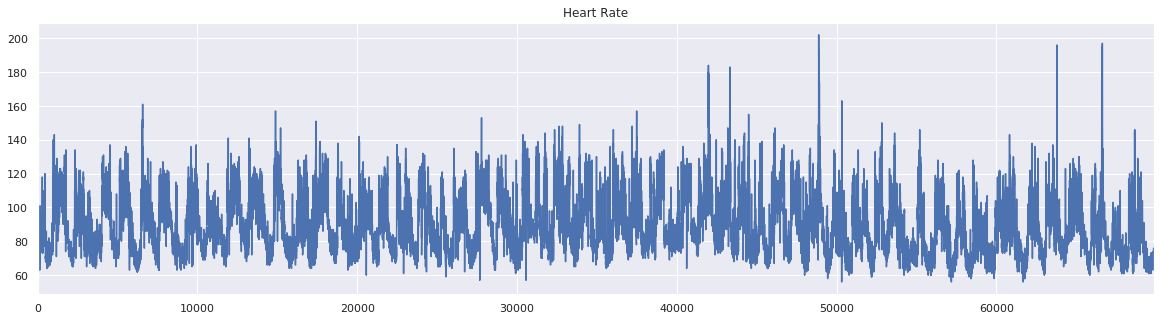

In [26]:
#Visualization of heart rate data
df_hr['point_value'].plot(figsize = (20, 5), title = "Heart Rate")
plt.show()

## The QQ Plot

In [27]:
import scipy.stats
import pylab

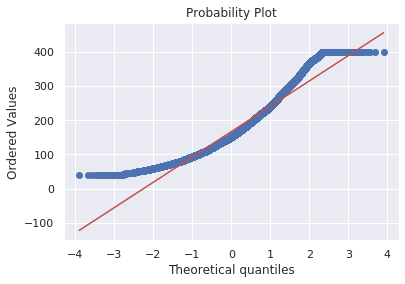

In [28]:
#Checks whether blood glucose data is distributed normally. 
scipy.stats.probplot(df_bg['point_value(mg/dL)'], plot = pylab)
pylab.show()

The blood glucose data is not normally distributed. This is because values cannot be negative (or zero), and so blood glucose levels off around 50. Similarly, there is an upper plateau as well, around 400. 

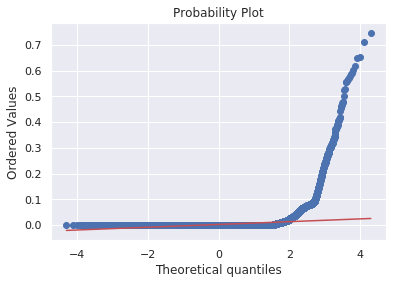

In [29]:
scipy.stats.probplot(df_da['point_value(kilometers)'], plot = pylab)
pylab.show()

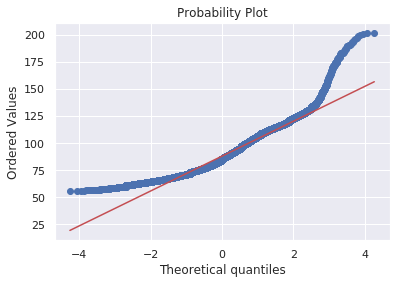

In [30]:
scipy.stats.probplot(df_hr['point_value'], plot = pylab)
pylab.show()

Activity levels and heart rate are also not normally distributed.

## Length of the time period

In [31]:
#This is not datetime yet
df_bg.point_timestamp.describe()

count                   14702
unique                  14702
top       2017-06-08 03:42:14
freq                        1
Name: point_timestamp, dtype: object

In [32]:
#Converting to datetime
df_bg.point_timestamp = pd.to_datetime(df_bg.point_timestamp, dayfirst = True)

In [33]:
#Datetime achieved
df_bg.head()

,point_value(mg/dL),point_timestamp,timezone_offset
0,142,2017-05-15 07:51:22,-700
1,140,2017-05-15 07:56:23,-700
2,138,2017-05-15 08:01:22,-700
3,136,2017-05-15 08:06:22,-700
4,130,2017-05-15 08:11:23,-700


In [34]:
df_bg.point_timestamp.describe()

count                   14702
unique                  14702
top       2017-06-09 04:02:10
freq                        1
first     2017-05-15 07:51:22
last      2017-07-15 07:49:50
Name: point_timestamp, dtype: object

In [35]:
df_bg_no_index = df_bg.copy()

In [36]:
#This copy dataframe will not have its index changed. This is useful for some methods.
df_bg_no_index.head()

,point_value(mg/dL),point_timestamp,timezone_offset
0,142,2017-05-15 07:51:22,-700
1,140,2017-05-15 07:56:23,-700
2,138,2017-05-15 08:01:22,-700
3,136,2017-05-15 08:06:22,-700
4,130,2017-05-15 08:11:23,-700


In [37]:
df_da.point_timestamp.describe()

count                   84920
unique                  84875
top       2017-06-13 21:01:00
freq                        2
Name: point_timestamp, dtype: object

In [38]:
#Set heartrate and distance to datetime as well.
df_da.point_timestamp = pd.to_datetime(df_da.point_timestamp, dayfirst = True)

In [39]:
df_da.head()

,point_value(kilometers),point_timestamp,timezone_offset,device
0,0.03607,2017-05-15 15:52:44,-700,iPhone
1,0.30443,2017-05-15 15:59:36,-700,iPhone
2,0.31764,2017-05-15 16:09:35,-700,iPhone
3,0.16387,2017-05-15 16:16:43,-700,iPhone
4,0.01675,2017-05-15 16:27:07,-700,iPhone


In [40]:
df_da.point_timestamp.describe()

count                   84920
unique                  84875
top       2017-05-29 17:07:00
freq                        2
first     2017-05-15 15:52:44
last      2017-07-14 17:45:00
Name: point_timestamp, dtype: object

In [41]:
df_hr.point_timestamp.describe()

count                   69851
unique                  69851
top       2017-06-03 11:30:00
freq                        1
Name: point_timestamp, dtype: object

In [42]:
df_hr.point_timestamp = pd.to_datetime(df_hr.point_timestamp, dayfirst = True)

In [43]:
df_hr.head()

,point_value,point_timestamp,timezone_offset
0,98,2017-05-16 22:16:00,-700
1,104,2017-05-16 22:17:00,-700
2,110,2017-05-16 22:18:00,-700
3,112,2017-05-16 22:19:00,-700
4,97,2017-05-16 22:20:00,-700


In [44]:
df_hr.point_timestamp.describe()

count                   69851
unique                  69851
top       2017-06-15 04:07:00
freq                        1
first     2017-05-16 22:16:00
last      2017-07-14 17:28:00
Name: point_timestamp, dtype: object

## Setting the Index

In [45]:
#Set the datetime as the index of the dataframe
df_bg.set_index("point_timestamp", inplace = True)

In [46]:
df_bg.head()

,point_value(mg/dL),timezone_offset
point_timestamp,,
2017-05-15 07:51:22,142,-700
2017-05-15 07:56:23,140,-700
2017-05-15 08:01:22,138,-700
2017-05-15 08:06:22,136,-700
2017-05-15 08:11:23,130,-700


In [47]:
df_bg_no_index.set_index("point_timestamp", inplace = True)

In [48]:
df_bg_no_index.head()

,point_value(mg/dL),timezone_offset
point_timestamp,,
2017-05-15 07:51:22,142,-700
2017-05-15 07:56:23,140,-700
2017-05-15 08:01:22,138,-700
2017-05-15 08:06:22,136,-700
2017-05-15 08:11:23,130,-700


In [49]:
df_da.set_index("point_timestamp", inplace = True)

In [50]:
df_da.head()

,point_value(kilometers),timezone_offset,device
point_timestamp,,,
2017-05-15 15:52:44,0.03607,-700,iPhone
2017-05-15 15:59:36,0.30443,-700,iPhone
2017-05-15 16:09:35,0.31764,-700,iPhone
2017-05-15 16:16:43,0.16387,-700,iPhone
2017-05-15 16:27:07,0.01675,-700,iPhone


In [51]:
df_hr.set_index("point_timestamp", inplace = True)

In [52]:
df_hr.head()

,point_value,timezone_offset
point_timestamp,,
2017-05-16 22:16:00,98,-700
2017-05-16 22:17:00,104,-700
2017-05-16 22:18:00,110,-700
2017-05-16 22:19:00,112,-700
2017-05-16 22:20:00,97,-700


## Setting the desired frequency

Measurements are taken at non-consistent periods. Therefore, the lowest common denominator for time is seconds. We will set the frequencies of all dataframes to seconds. Setting a frequency to the dataframe is necessary for some, but not all methods. Therefore, we will have one copy of the dataframe (df_bg) with an index and frequency set, and another copy (df_bg_no_index) which is unchanged.

In [53]:
df_bg = df_bg.asfreq('S')

In [54]:
df_bg.head()

,point_value(mg/dL),timezone_offset
point_timestamp,,
2017-05-15 07:51:22,142.0,-700.0
2017-05-15 07:51:23,NaN,NaN
2017-05-15 07:51:24,NaN,NaN
2017-05-15 07:51:25,NaN,NaN
2017-05-15 07:51:26,NaN,NaN


In [55]:
df_da[df_da.index.duplicated()]

,point_value(kilometers),timezone_offset,device
point_timestamp,,,
2017-05-16 20:17:00,0.00000,-700,FitbitWatch
2017-05-18 20:39:00,0.00000,-700,FitbitWatch
2017-05-22 21:47:00,0.00000,-700,FitbitWatch
2017-05-23 19:43:00,0.01092,-700,iPhone
2017-05-24 05:37:00,0.01060,-700,iPhone
2017-05-24 22:37:00,0.00000,-700,FitbitWatch
2017-05-27 02:43:00,0.00854,-700,iPhone
2017-05-27 04:23:00,0.00000,-700,FitbitWatch
2017-05-29 00:13:00,0.00000,-700,FitbitWatch


In [56]:
#Removing duplicated values
df_da = df_da[~df_da.index.duplicated()]

In [57]:
df_da = df_da.asfreq('S')

In [58]:
df_da.head()

,point_value(kilometers),timezone_offset,device
point_timestamp,,,
2017-05-15 15:52:44,0.03607,-700.0,iPhone
2017-05-15 15:52:45,NaN,NaN,NaN
2017-05-15 15:52:46,NaN,NaN,NaN
2017-05-15 15:52:47,NaN,NaN,NaN
2017-05-15 15:52:48,NaN,NaN,NaN


In [59]:
df_hr = df_hr.asfreq('S')

In [60]:
df_hr.head()

,point_value,timezone_offset
point_timestamp,,
2017-05-16 22:16:00,98.0,-700.0
2017-05-16 22:16:01,NaN,NaN
2017-05-16 22:16:02,NaN,NaN
2017-05-16 22:16:03,NaN,NaN
2017-05-16 22:16:04,NaN,NaN


## Handling Missing Values

In [61]:
df_bg.isna().head()

,point_value(mg/dL),timezone_offset
point_timestamp,,
2017-05-15 07:51:22,False,False
2017-05-15 07:51:23,True,True
2017-05-15 07:51:24,True,True
2017-05-15 07:51:25,True,True
2017-05-15 07:51:26,True,True


In [62]:
#Splitting up into seconds created a lot of NaNs.
df_bg.isna().sum()

point_value(mg/dL)    5255607
timezone_offset       5255607
dtype: int64

In [63]:
#We will use forward fill to fill in all NaN values.
df_bg['point_value(mg/dL)'] = df_bg['point_value(mg/dL)'].fillna(method = 'ffill')

In [64]:
df_bg.head()

,point_value(mg/dL),timezone_offset
point_timestamp,,
2017-05-15 07:51:22,142.0,-700.0
2017-05-15 07:51:23,142.0,NaN
2017-05-15 07:51:24,142.0,NaN
2017-05-15 07:51:25,142.0,NaN
2017-05-15 07:51:26,142.0,NaN


In [65]:
df_da.isna().head()

,point_value(kilometers),timezone_offset,device
point_timestamp,,,
2017-05-15 15:52:44,False,False,False
2017-05-15 15:52:45,True,True,True
2017-05-15 15:52:46,True,True,True
2017-05-15 15:52:47,True,True,True
2017-05-15 15:52:48,True,True,True


In [66]:
df_da.isna().sum()

point_value(kilometers)    5105862
timezone_offset            5105862
device                     5105862
dtype: int64

In [67]:
df_da['point_value(kilometers)'] = df_da['point_value(kilometers)'].fillna(method = 'ffill')

In [68]:
df_da.head()

,point_value(kilometers),timezone_offset,device
point_timestamp,,,
2017-05-15 15:52:44,0.03607,-700.0,iPhone
2017-05-15 15:52:45,0.03607,NaN,NaN
2017-05-15 15:52:46,0.03607,NaN,NaN
2017-05-15 15:52:47,0.03607,NaN,NaN
2017-05-15 15:52:48,0.03607,NaN,NaN


In [69]:
df_hr.isna().head()

,point_value,timezone_offset
point_timestamp,,
2017-05-16 22:16:00,False,False
2017-05-16 22:16:01,True,True
2017-05-16 22:16:02,True,True
2017-05-16 22:16:03,True,True
2017-05-16 22:16:04,True,True


In [70]:
df_hr.isna().sum()

point_value        5010470
timezone_offset    5010470
dtype: int64

In [71]:
df_hr['point_value'] = df_hr['point_value'].fillna(method = 'ffill')

In [72]:
df_hr.head()

,point_value,timezone_offset
point_timestamp,,
2017-05-16 22:16:00,98.0,-700.0
2017-05-16 22:16:01,98.0,NaN
2017-05-16 22:16:02,98.0,NaN
2017-05-16 22:16:03,98.0,NaN
2017-05-16 22:16:04,98.0,NaN


## Reducing dataset size

In [73]:
#The dataset is too large, and fitting a model with take too long. So we can discretize into 60 second bins.
df_bg.shape

(5270309, 2)

In [74]:
df_bg = df_bg.asfreq('T')

In [75]:
df_bg.isna().sum()

point_value(mg/dL)        0
timezone_offset       87566
dtype: int64

In [76]:
df_bg.shape

(87839, 2)

In [77]:
df_da.shape

(5190737, 3)

In [78]:
df_da = df_da.asfreq('T')

In [79]:
df_da.isna().sum()

point_value(kilometers)        0
timezone_offset            86485
device                     86485
dtype: int64

In [80]:
df_da.shape

(86513, 3)

In [81]:
df_hr.shape

(5080321, 2)

In [82]:
df_hr = df_hr.asfreq('T')

In [83]:
df_hr.isna().sum()

point_value            0
timezone_offset    14822
dtype: int64

In [84]:
df_hr.shape

(84673, 2)

## Simplifying the dataset

In [85]:
#Removing unnecessary columns.
df_bg['bg_level'] = df_bg['point_value(mg/dL)']

In [86]:
#All measurements are taken in the same timezone (std of timezone is 0). Therefore, we remove the column.
df_bg.describe()

,point_value(mg/dL),timezone_offset,bg_level
count,87839.000000,273.0,87839.000000
mean,162.337105,-700.0,162.337105
std,77.190067,0.0,77.190067
min,39.000000,-700.0,39.000000
25%,101.000000,-700.0,101.000000
50%,148.000000,-700.0,148.000000
75%,203.000000,-700.0,203.000000
max,401.000000,-700.0,401.000000


In [87]:
#All timezone offsets are -700 for df_bg, so we can remove this column

In [88]:
df_bg_no_index['bg_level'] = df_bg_no_index['point_value(mg/dL)']

In [89]:
del df_bg['timezone_offset']

In [90]:
del df_bg['point_value(mg/dL)']

In [91]:
del df_bg_no_index['timezone_offset']

In [92]:
del df_bg_no_index['point_value(mg/dL)']

In [93]:
df_bg.describe()

,bg_level
count,87839.000000
mean,162.337105
std,77.190067
min,39.000000
25%,101.000000
50%,148.000000
75%,203.000000
max,401.000000


In [94]:
df_bg_no_index.head()

,bg_level
point_timestamp,
2017-05-15 07:51:22,142
2017-05-15 07:56:23,140
2017-05-15 08:01:22,138
2017-05-15 08:06:22,136
2017-05-15 08:11:23,130


In [95]:
#Creating a dataframe with only 1 column of values
df_bg_no_index_single = df_bg_no_index.copy()

In [96]:
#Converting to a numpy ndarray
values = DataFrame(df_bg_no_index.values)

In [97]:
#Creating a 2 column dataframe, with column 1 a 1-lag version of column 2. This is for the persistence model.
df_bg_no_index = concat([values.shift(1), values], axis=1)


In [98]:
df_bg_no_index

,0,0
0,NaN,142
1,142.0,140
2,140.0,138
3,138.0,136
4,136.0,130
...,...,...
14697,217.0,216
14698,216.0,220
14699,220.0,220
14700,220.0,223


In [99]:
df_bg_no_index.columns = ['bg_level(t-1)', 'bg_level(t)']

In [100]:
df_bg_no_index.head()

,bg_level(t-1),bg_level(t)
0,NaN,142
1,142.0,140
2,140.0,138
3,138.0,136
4,136.0,130


In [101]:
df_bg_no_index = df_bg_no_index.values

In [102]:
df_bg_no_index_single = df_bg_no_index_single.values

In [103]:
df_da['distance'] = df_da['point_value(kilometers)']            

In [104]:
df_da.describe()

,point_value(kilometers),timezone_offset,distance
count,86513.000000,28.0,86513.000000
mean,0.003078,-700.0,0.003078
std,0.022917,0.0,0.022917
min,0.000000,-700.0,0.000000
25%,0.000000,-700.0,0.000000
50%,0.000000,-700.0,0.000000
75%,0.000000,-700.0,0.000000
max,0.747830,-700.0,0.747830


In [105]:
#All timezone offsets are -700 for df_bg, so we can remove this column

In [106]:
#How is distance measured - through GPS or through a pedometer? Pedometer would be stride length * steps taken since last measurement. 

In [107]:
del df_da['timezone_offset']

In [108]:
del df_da['point_value(kilometers)']

In [109]:
del df_da['device']

In [110]:
df_da.describe()

,distance
count,86513.000000
mean,0.003078
std,0.022917
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,0.747830


In [111]:
df_hr['heartrate'] = df_hr['point_value']          

In [112]:
df_hr.describe()

,point_value,timezone_offset,heartrate
count,84673.000000,69851.0,84673.000000
mean,87.739834,-700.0,87.739834
std,17.017304,0.0,17.017304
min,56.000000,-700.0,56.000000
25%,75.000000,-700.0,75.000000
50%,85.000000,-700.0,85.000000
75%,99.000000,-700.0,99.000000
max,202.000000,-700.0,202.000000


In [113]:
#All timezone offsets are -700 for df_bg, so we can remove this column

In [114]:
del df_hr['timezone_offset']

In [115]:
del df_hr['point_value']

In [116]:
df_hr.describe()

,heartrate
count,84673.000000
mean,87.739834
std,17.017304
min,56.000000
25%,75.000000
50%,85.000000
75%,99.000000
max,202.000000


## Sync the timedate indices of the three dataframes

In order for ARIMAX to utilize exogenous dataframes for blood glucose prediction, it is necessary that the exogenous dataframes have a datapoint corresponding to the datapoint in the respective position of the blood glucose dataframe. Therefore, I will cut the first chunk of df_bg and df_da so that the first example of each of the three dataframes corresponds to 2017-05-16 22:16 (the three dataframes are a few seconds off - this doesn't matter). 

In [117]:
df_bg_synced = df_bg.iloc[2305:]
df_bg_synced.head()

,bg_level
point_timestamp,
2017-05-16 22:16:22,121.0
2017-05-16 22:17:22,121.0
2017-05-16 22:18:22,121.0
2017-05-16 22:19:22,144.0
2017-05-16 22:20:22,144.0


In [118]:
df_hr_synced = df_hr.copy()
df_hr_synced.head()

,heartrate
point_timestamp,
2017-05-16 22:16:00,98.0
2017-05-16 22:17:00,104.0
2017-05-16 22:18:00,110.0
2017-05-16 22:19:00,112.0
2017-05-16 22:20:00,97.0


In [119]:
df_da_synced = df_da.iloc[1823:]
df_da_synced.head()

,distance
point_timestamp,
2017-05-16 22:15:44,0.0
2017-05-16 22:16:44,0.0
2017-05-16 22:17:44,0.0
2017-05-16 22:18:44,0.0
2017-05-16 22:19:44,0.0


Confirm they are siynced throughout the whole dataset by checking the tails.

In [120]:
df_bg_synced = df_bg_synced.iloc[:84673]
df_bg_synced.tail()

,bg_level
point_timestamp,
2017-07-14 17:24:22,171.0
2017-07-14 17:25:22,173.0
2017-07-14 17:26:22,173.0
2017-07-14 17:27:22,173.0
2017-07-14 17:28:22,173.0


In [121]:
df_da_synced = df_da_synced.iloc[:84673]
df_da_synced.tail()

,distance
point_timestamp,
2017-07-14 17:23:44,0.0
2017-07-14 17:24:44,0.0
2017-07-14 17:25:44,0.0
2017-07-14 17:26:44,0.0
2017-07-14 17:27:44,0.0


In [122]:
df_hr_synced.tail()

,heartrate
point_timestamp,
2017-07-14 17:24:00,74.0
2017-07-14 17:25:00,76.0
2017-07-14 17:26:00,71.0
2017-07-14 17:27:00,70.0
2017-07-14 17:28:00,70.0


Confirm synchronicity

In [123]:
df_bg_synced.shape

(84673, 1)

In [124]:
df_da_synced.shape

(84673, 1)

In [125]:
df_hr_synced.shape

(84673, 1)

## Splitting the data

In [126]:
#The training data consists of the first 55% of the total data. This approximately represents the first month.
size = int(len(df_bg) * 0.55)

In [127]:
df_bgtrain = df_bg.iloc[:size]

In [128]:
df_bgtest = df_bg.iloc[size:]

In [129]:
df_bgtrain.tail()

,bg_level
point_timestamp,
2017-06-17 20:57:22,152.0
2017-06-17 20:58:22,152.0
2017-06-17 20:59:22,152.0
2017-06-17 21:00:22,152.0
2017-06-17 21:01:22,152.0


In [130]:
df_bgtest.head()

,bg_level
point_timestamp,
2017-06-17 21:02:22,152.0
2017-06-17 21:03:22,152.0
2017-06-17 21:04:22,152.0
2017-06-17 21:05:22,152.0
2017-06-17 21:06:22,152.0


In [131]:
sizenoindexsingle = int(len(df_bg_no_index_single) * 0.55)
trainsingle, testsingle = df_bg_no_index_single[:sizenoindexsingle], df_bg_no_index_single[sizenoindexsingle:]

In [132]:
sizenoindex = int(len(df_bg_no_index) * 0.55)
train, test = df_bg_no_index[:sizenoindex], df_bg_no_index[sizenoindex:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [133]:
sizeda = int(len(df_da) * 0.528)

In [134]:
df_datrain = df_da.iloc[:sizeda]

In [135]:
df_datest = df_da.iloc[sizeda:]

In [136]:
df_datrain.tail()

,distance
point_timestamp,
2017-06-16 09:05:44,0.0
2017-06-16 09:06:44,0.0
2017-06-16 09:07:44,0.0
2017-06-16 09:08:44,0.0
2017-06-16 09:09:44,0.0


In [137]:
df_datest.head()

,distance
point_timestamp,
2017-06-16 09:10:44,0.0
2017-06-16 09:11:44,0.0
2017-06-16 09:12:44,0.0
2017-06-16 09:13:44,0.0
2017-06-16 09:14:44,0.0


In [138]:
sizehr = int(len(df_hr) * 0.55)

In [139]:
df_hrtrain = df_hr.iloc[:sizehr]

In [140]:
df_hrtest = df_hr.iloc[sizehr:]

In [141]:
df_hrtrain.tail()

,heartrate
point_timestamp,
2017-06-18 06:21:00,75.0
2017-06-18 06:22:00,75.0
2017-06-18 06:23:00,75.0
2017-06-18 06:24:00,75.0
2017-06-18 06:25:00,75.0


In [142]:
df_hrtest.head()

,heartrate
point_timestamp,
2017-06-18 06:26:00,75.0
2017-06-18 06:27:00,75.0
2017-06-18 06:28:00,75.0
2017-06-18 06:29:00,75.0
2017-06-18 06:30:00,75.0


In [143]:
df_bg_synced = df_bg_synced.reset_index()

In [144]:
df_hr_synced = df_hr_synced.reset_index()

In [145]:
df_da_synced = df_da_synced.reset_index()

In [146]:

df_da_synced['heartrate'] = df_hr_synced['heartrate']


In [147]:
df_da_synced.tail()

,point_timestamp,distance,heartrate
84668,2017-07-14 17:23:44,0.0,74.0
84669,2017-07-14 17:24:44,0.0,76.0
84670,2017-07-14 17:25:44,0.0,71.0
84671,2017-07-14 17:26:44,0.0,70.0
84672,2017-07-14 17:27:44,0.0,70.0


In [148]:
#The training data consists of the first 55% of the total data. This approximately represents the first month.
size = int(len(df_bg_synced) * 0.55)
df_bg_synced_train = df_bg_synced.iloc[:size]
df_bg_synced_test = df_bg_synced.iloc[size:]

In [149]:
#The training data consists of the first 55% of the total data. This approximately represents the first month.
size = int(len(df_da_synced) * 0.55)
df_da_synced_train = df_da_synced.iloc[:size]
df_da_synced_test = df_da_synced.iloc[size:]

In [150]:
#The training data consists of the first 55% of the total data. This approximately represents the first month.
size = int(len(df_hr_synced) * 0.55)
df_hr_synced_train = df_hr_synced.iloc[:size]
df_hr_synced_test = df_hr_synced.iloc[size:]

## White Noise

Created for reference

In [151]:
wn = np.random.normal(loc = df_bgtrain.bg_level.mean(), scale = df_bgtrain.bg_level.std(), size = len(df_bgtrain))

In [152]:
df_bgtrain['wn'] = wn

In [153]:
df_bgtrain.describe()

,bg_level,wn
count,48311.000000,48311.000000
mean,170.105318,170.444340
std,83.419371,83.241960
min,39.000000,-159.654662
25%,104.000000,114.765583
50%,151.000000,170.768084
75%,221.000000,226.340667
max,401.000000,502.814742


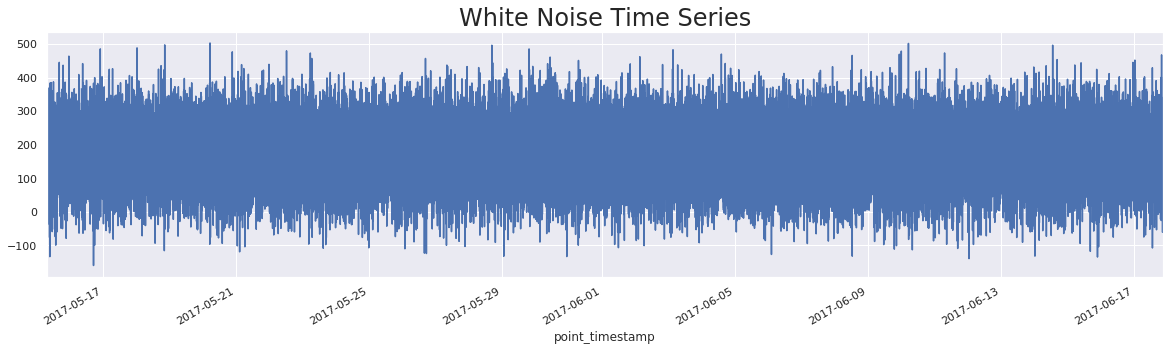

In [154]:
df_bgtrain.wn.plot(figsize = (20, 5))
plt.title('White Noise Time Series', size = 24)
plt.show()

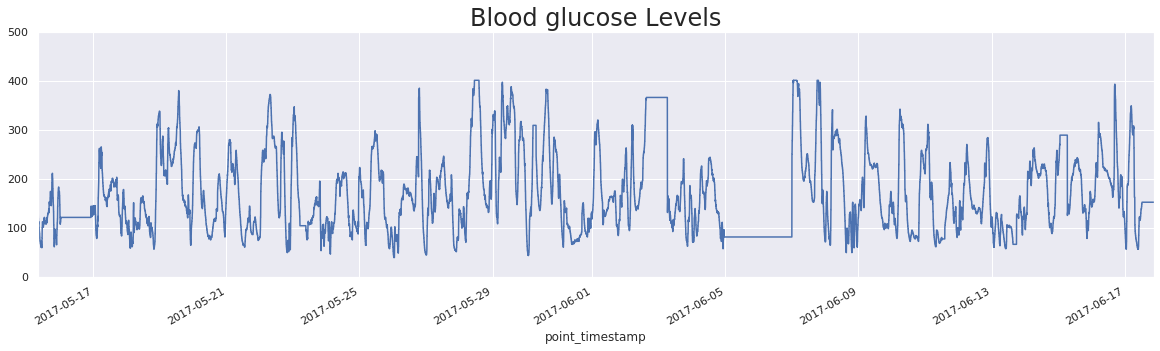

In [155]:
#This shows data that has been discretized. That is why there are many flat points.
df_bgtrain.bg_level.plot(figsize = (20, 5))
plt.title('Blood glucose Levels', size = 24)
plt.ylim(0, 500)
plt.show()

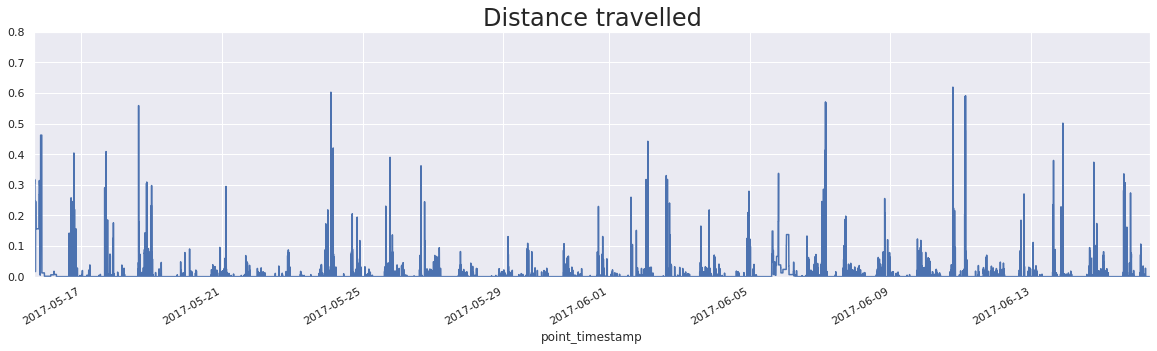

In [156]:
df_datrain.distance.plot(figsize = (20, 5))
plt.title('Distance travelled', size = 24)
plt.ylim(0, 0.8)
plt.show()

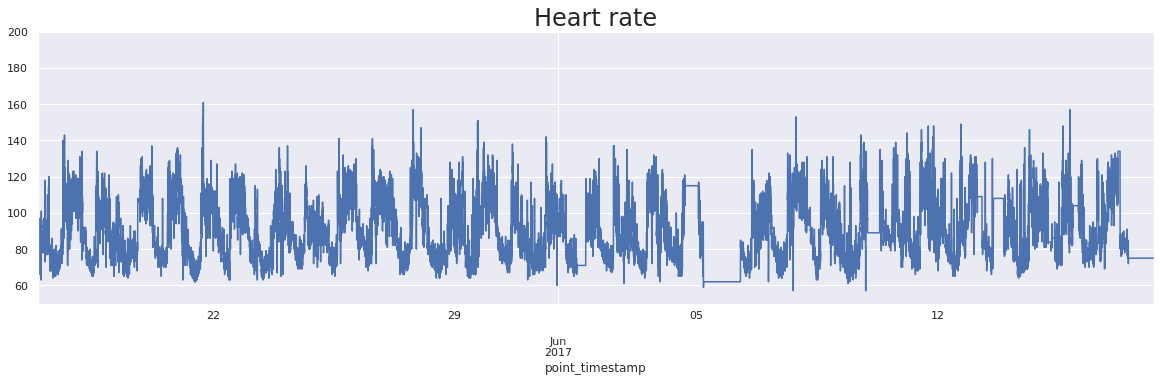

In [157]:
df_hrtrain.heartrate.plot(figsize = (20, 5))
plt.title('Heart rate', size = 24)
plt.ylim(50, 200)
plt.show()

## Stationarity

In [158]:
#We use the Dickey-Fuller test to check for stationarity. 
#P value is 6.5e-16. Blood glucose data is stationary.
sts.adfuller(df_bgtrain.bg_level)

(-9.392016488427307,
 6.52265894326754e-16,
 25,
 48285,
 {'1%': -3.430485438493906,
  '5%': -2.861599860985914,
  '10%': -2.566801862031178},
 230647.74013679533)

In [159]:
#Null hypothesis is rejected = bg_level is stationary
#No transformations required

In [160]:
sts.adfuller(df_datrain.distance)

(-14.795112454727121,
 2.141527216411365e-27,
 56,
 45621,
 {'1%': -3.4304933477561375,
  '5%': -2.8616033566302224,
  '10%': -2.5668037226622067},
 -249244.1982674867)

In [161]:
#Null hypothesis is rejected = distance is stationary

In [162]:
sts.adfuller(df_hrtrain.heartrate)

(-9.665370611525699,
 1.3195956704158924e-16,
 45,
 46524,
 {'1%': -3.430490565317679,
  '5%': -2.8616021268812935,
  '10%': -2.5668030681019998},
 260337.10296773753)

In [163]:
#Null hypothesis is rejected = heart rate is stationary

## Seasonality

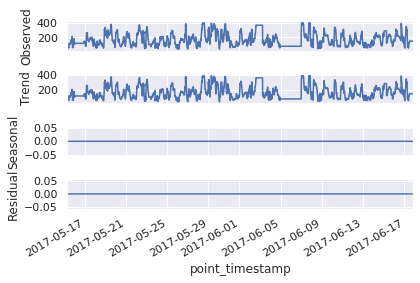

In [164]:
s_dec_additive_bgtrain = seasonal_decompose(df_bgtrain.bg_level, model = "additive", freq = 1)
s_dec_additive_bgtrain.plot()
plt.show()

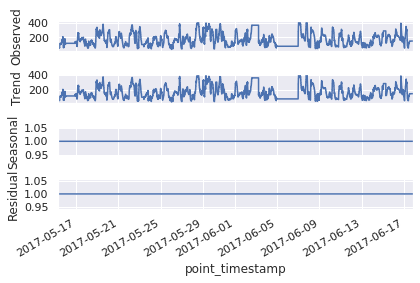

In [165]:
s_dec_multiplicative_bgtrain = seasonal_decompose(df_bgtrain.bg_level, model = "multiplicative", freq = 1)
s_dec_multiplicative_bgtrain.plot()
plt.show()

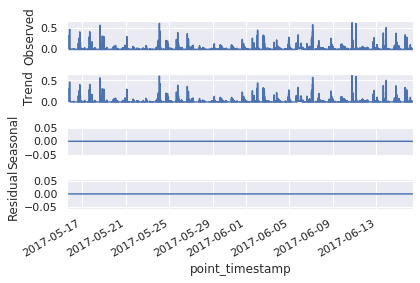

In [166]:
s_dec_additive_datrain = seasonal_decompose(df_datrain.distance, model = "additive", freq = 1)
s_dec_additive_datrain.plot()
plt.show()

In [167]:
#Multiplicative seasonality is not appropriate for zero and negative values. Therefore, not necessary to do on distance data

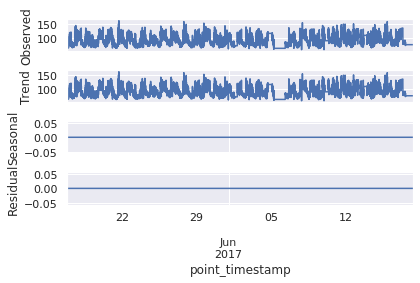

In [168]:
s_dec_additive_hrtrain = seasonal_decompose(df_hrtrain.heartrate, model = "additive", freq = 1)
s_dec_additive_hrtrain.plot()
plt.show()

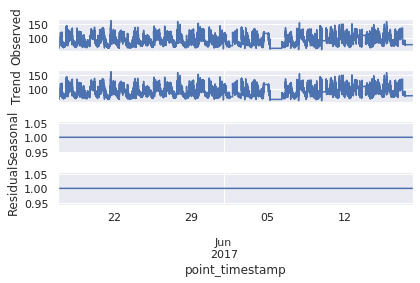

In [169]:
s_dec_multiplicative_hrtrain = seasonal_decompose(df_hrtrain.heartrate, model = "multiplicative", freq = 1)
s_dec_multiplicative_hrtrain.plot()
plt.show()

There is no evidence of seasonality in any of the dataframes.

## Lag Plot

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


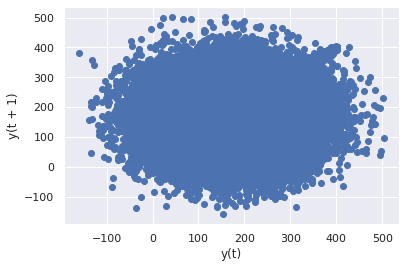

In [170]:
lag_plot(df_bgtrain)
pyplot.show()

The lag-1 plot does not immediately display an easily observed pattern.

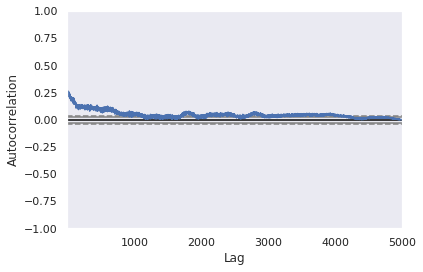

In [171]:
autocorrelation_plot(df_bgtrain[0:5000])

## ACF

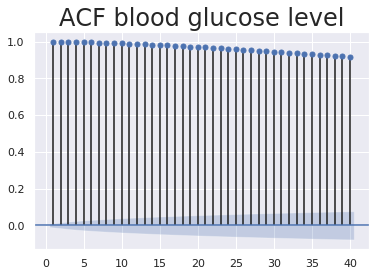

In [172]:
sgt.plot_acf(df_bgtrain.bg_level, lags = 40, zero = False)
plt.title("ACF blood glucose level", size = 24)
plt.show()

In [173]:
#ACF shows high autocorrelation with lagged values

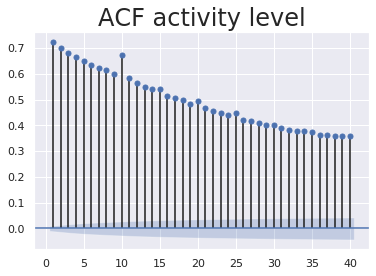

In [174]:
sgt.plot_acf(df_datrain.distance, lags = 40, zero = False)
plt.title("ACF activity level", size = 24)
plt.show()

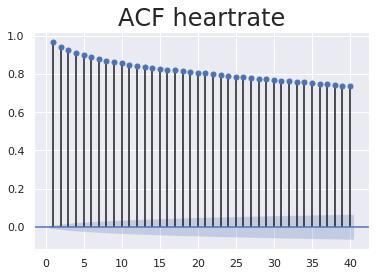

In [175]:
sgt.plot_acf(df_hrtrain.heartrate, lags = 40, zero = False)
plt.title("ACF heartrate", size = 24)
plt.show()

## PACF

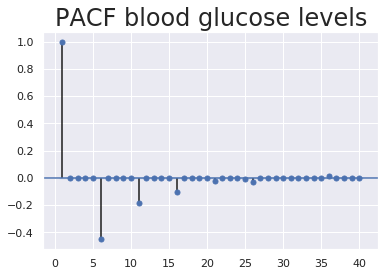

In [176]:
sgt.plot_pacf(df_bgtrain.bg_level, lags = 40, zero = False, method = ('ols'))
plt.title("PACF blood glucose levels", size = 24)
plt.show()

In [177]:
#This PACF shows that the lag-1 has the highest correlation with the current value. 
#Intereestingly, there is a negative correlation with values around lag-5. This may be from a "bounce back" effect of blood glucose wanting to go higher after being low, or going lower after being high.

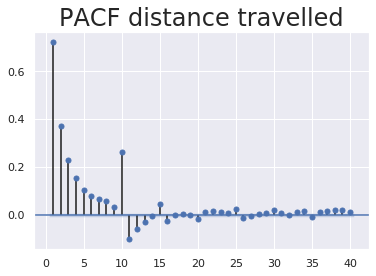

In [178]:
sgt.plot_pacf(df_datrain.distance, lags = 40, zero = False, method = ('ols'))
plt.title("PACF distance travelled", size = 24)
plt.show()

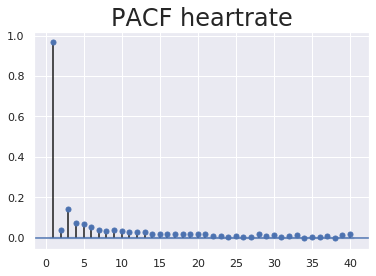

In [179]:
sgt.plot_pacf(df_hrtrain.heartrate, lags = 40, zero = False, method = ('ols'))
plt.title("PACF heartrate", size = 24)
plt.show()

### Creating returns

In [180]:
#Analyzing the percent change.
df_bgtrain['returns'] = df_bgtrain.bg_level.pct_change(1)*100

In [181]:
#Creating squared returns
df_bgtrain['sq_returns'] = df_bgtrain.returns.mul(df_bgtrain.returns)

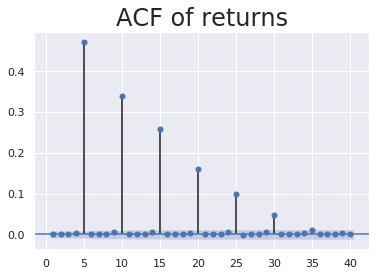

In [182]:
sgt.plot_acf(df_bgtrain.returns[1:], zero = False, lags = 40)
plt.title('ACF of returns', size = 24)
plt.show()

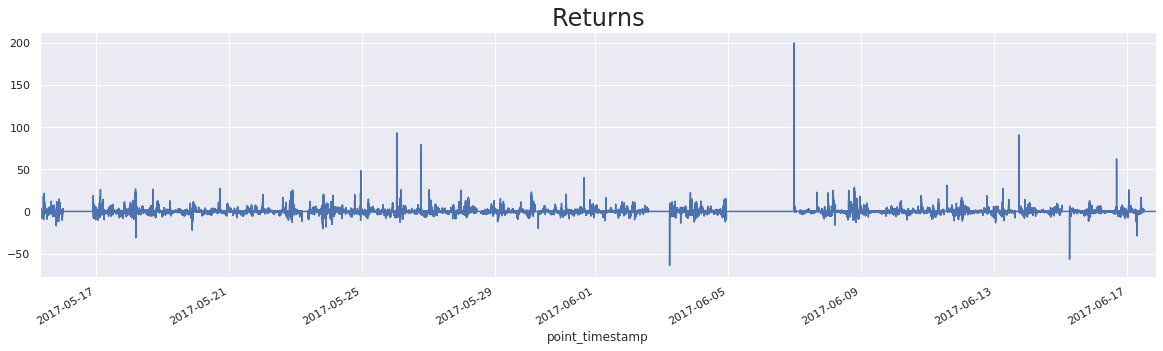

In [183]:
df_bgtrain.returns.plot(figsize=(20,5))
plt.title("Returns", size = 24)
plt.show()

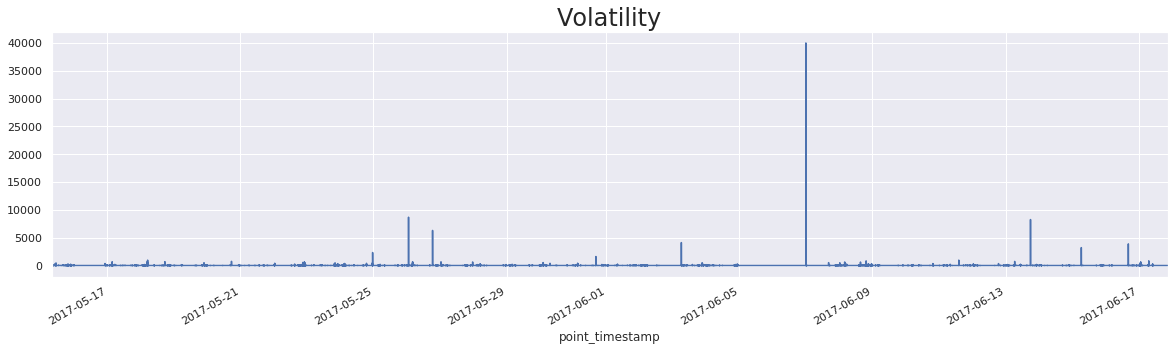

In [184]:
df_bgtrain.sq_returns.plot(figsize=(20,5))
plt.title("Volatility", size = 24)
plt.show()

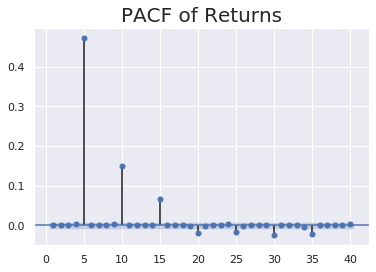

In [185]:
sgt.plot_pacf(df_bgtrain.returns[1:], lags = 40, alpha = 0.05, zero = False , method = ('ols'))
plt.title("PACF of Returns", size = 20)
plt.show()

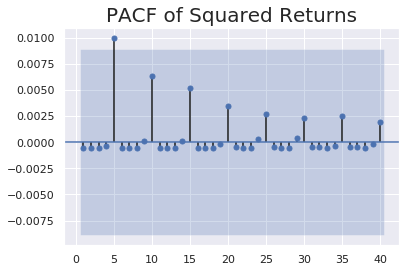

In [186]:
sgt.plot_pacf(df_bgtrain.sq_returns[1:], lags = 40, alpha = 0.05, zero = False , method = ('ols'))
plt.title("PACF of Squared Returns", size = 20)
plt.show()

## Persistance Model Baseline

The persistance model is a commonly used baseline. It simply predicts the lag-1 value for any timepoint.

In [187]:
# persistence model
def model_persistence(x):
    return x

In [188]:
df_bgtest.shape[0]

39528

In [189]:
# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)


In [190]:
predictions

[170.0,
 173.0,
 175.0,
 179.0,
 178.0,
 180.0,
 184.0,
 191.0,
 199.0,
 210.0,
 223.0,
 362.0,
 378.0,
 389.0,
 393.0,
 393.0,
 392.0,
 383.0,
 375.0,
 370.0,
 361.0,
 340.0,
 334.0,
 327.0,
 319.0,
 304.0,
 296.0,
 289.0,
 282.0,
 277.0,
 270.0,
 264.0,
 255.0,
 242.0,
 234.0,
 229.0,
 225.0,
 222.0,
 219.0,
 216.0,
 201.0,
 190.0,
 182.0,
 175.0,
 170.0,
 162.0,
 155.0,
 146.0,
 140.0,
 140.0,
 147.0,
 151.0,
 153.0,
 163.0,
 161.0,
 160.0,
 161.0,
 164.0,
 169.0,
 182.0,
 188.0,
 197.0,
 203.0,
 207.0,
 208.0,
 208.0,
 205.0,
 201.0,
 192.0,
 189.0,
 185.0,
 186.0,
 187.0,
 190.0,
 198.0,
 204.0,
 200.0,
 188.0,
 182.0,
 181.0,
 170.0,
 156.0,
 146.0,
 138.0,
 134.0,
 128.0,
 124.0,
 123.0,
 122.0,
 124.0,
 128.0,
 130.0,
 131.0,
 133.0,
 132.0,
 128.0,
 124.0,
 119.0,
 114.0,
 108.0,
 103.0,
 97.0,
 93.0,
 89.0,
 84.0,
 79.0,
 73.0,
 68.0,
 63.0,
 59.0,
 56.0,
 56.0,
 56.0,
 60.0,
 73.0,
 90.0,
 113.0,
 132.0,
 153.0,
 171.0,
 183.0,
 186.0,
 189.0,
 187.0,
 188.0,
 189.0,
 188.0,

In [191]:
test_y[0:100].shape

(100,)

Test MSE: 44.371


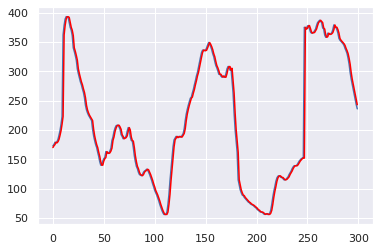

In [192]:
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
pyplot.plot(test_y[0:300])
pyplot.plot(predictions[0:300], color='red')
pyplot.show()

## The AR(1) Model

Autoregression is a time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step.

In [193]:
model_ar = ARMA(df_bgtrain.bg_level, order=(1,0))

In [194]:
results_ar = model_ar.fit()

In [195]:
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               bg_level   No. Observations:                48311
Model:                     ARMA(1, 0)   Log Likelihood             -122075.969
Method:                       css-mle   S.D. of innovations              3.028
Date:                Fri, 17 Jan 2020   AIC                         244157.938
Time:                        19:00:28   BIC                         244184.294
Sample:                    05-15-2017   HQIC                        244166.207
                         - 06-17-2017                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            168.7116     19.738      8.548      0.000     130.026     207.397
ar.L1.bg_level     0.9993      0.000   6140.448      0.000       0.999       1.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0007           +0.0000j            1.0007            0.0000
-----------------------------------------------------------------------------
"""

Both the constant and the first coefficient are significant.

## Higher-Lag AR Models

In [196]:
model_ar_2 = ARMA(df_bgtrain.bg_level, order=(2,0))
results_ar_2 = model_ar_2.fit()
results_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               bg_level   No. Observations:                48311
Model:                     ARMA(2, 0)   Log Likelihood             -122075.967
Method:                       css-mle   S.D. of innovations              3.028
Date:                Fri, 17 Jan 2020   AIC                         244159.934
Time:                        19:00:32   BIC                         244195.076
Sample:                    05-15-2017   HQIC                        244170.959
                         - 06-17-2017                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            169.3903     19.735      8.583      0.000     130.711     208.070
ar.L1.bg_level     0.9997      0.005    220.111      0.000       0.991       1.009
ar.L2.bg_level    -0.0003      0.005     -0.073      0.942      -0.009       0.009
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0007           +0.0000j            1.0007            0.0000
AR.2         3034.9433           +0.0000j         3034.9433            0.0000
-----------------------------------------------------------------------------
"""

Now, the constant and first coefficient are significant, but not the second coefficient.

In [197]:
model_ar_3 = ARMA(df_bgtrain.bg_level, order=(3,0))
results_ar_3 = model_ar_3.fit()
results_ar_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               bg_level   No. Observations:                48311
Model:                     ARMA(3, 0)   Log Likelihood             -122075.966
Method:                       css-mle   S.D. of innovations              3.028
Date:                Fri, 17 Jan 2020   AIC                         244161.932
Time:                        19:00:37   BIC                         244205.859
Sample:                    05-15-2017   HQIC                        244175.714
                         - 06-17-2017                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            170.1051     19.733      8.620      0.000     131.429     208.781
ar.L1.bg_level     0.9997      0.005    220.111      0.000       0.991       1.009
ar.L2.bg_level -6.524e-07      0.006     -0.000      1.000      -0.013       0.013
ar.L3.bg_level    -0.0003      0.005     -0.072      0.942      -0.009       0.009
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0007           +0.0000j            1.0007            0.0000
AR.2           54.6153           +0.0000j           54.6153            0.0000
AR.3          -55.6180           +0.0000j           55.6180            0.5000
-----------------------------------------------------------------------------
"""

In [198]:
model_ar_4 = ARMA(df_bgtrain.bg_level, order=(4,0))
results_ar_4 = model_ar_4.fit()
results_ar_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               bg_level   No. Observations:                48311
Model:                     ARMA(4, 0)   Log Likelihood             -122075.961
Method:                       css-mle   S.D. of innovations              3.028
Date:                Fri, 17 Jan 2020   AIC                         244163.923
Time:                        19:00:47   BIC                         244216.635
Sample:                    05-15-2017   HQIC                        244180.461
                         - 06-17-2017                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            168.9932     19.724      8.568      0.000     130.334     207.652
ar.L1.bg_level     0.9997      0.005    220.110      0.000       0.991       1.009
ar.L2.bg_level -8.862e-07      0.006     -0.000      1.000      -0.013       0.013
ar.L3.bg_level  4.008e-06      0.006      0.001      1.000      -0.013       0.013
ar.L4.bg_level    -0.0003      0.005     -0.073      0.942      -0.009       0.009
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0007           -0.0000j            1.0007           -0.0000
AR.2           14.0896           -0.0000j           14.0896           -0.0000
AR.3           -7.5391          -12.5140j           14.6095           -0.3363
AR.4           -7.5391          +12.5140j           14.6095            0.3363
-----------------------------------------------------------------------------
"""

In [199]:
model_ar_5 = ARMA(df_bgtrain.bg_level, order=(5,0))
results_ar_5 = model_ar_5.fit()
results_ar_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               bg_level   No. Observations:                48311
Model:                     ARMA(5, 0)   Log Likelihood             -122075.686
Method:                       css-mle   S.D. of innovations              3.028
Date:                Fri, 17 Jan 2020   AIC                         244165.372
Time:                        19:00:59   BIC                         244226.870
Sample:                    05-15-2017   HQIC                        244184.667
                         - 06-17-2017                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            170.1049     19.666      8.650      0.000     131.561     208.649
ar.L1.bg_level     0.9997      0.005    220.106      0.000       0.991       1.009
ar.L2.bg_level -2.136e-08      0.006  -3.32e-06      1.000      -0.013       0.013
ar.L3.bg_level  1.267e-07      0.006   1.97e-05      1.000      -0.013       0.013
ar.L4.bg_level     0.0031      0.006      0.475      0.635      -0.010       0.016
ar.L5.bg_level    -0.0034      0.005     -0.745      0.456      -0.012       0.006
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0007           -0.0000j            1.0007           -0.0000
AR.2           -4.1644           -0.0000j            4.1644           -0.5000
AR.3           -0.0232           -4.1498j            4.1499           -0.2509
AR.4           -0.0232           +4.1498j            4.1499            0.2509
AR.5            4.1125           -0.0000j            4.1125           -0.0000
-----------------------------------------------------------------------------
"""

In [200]:
model_ar_6 = ARMA(df_bgtrain.bg_level, order=(6,0))
results_ar_6 = model_ar_6.fit()
results_ar_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               bg_level   No. Observations:                48311
Model:                     ARMA(6, 0)   Log Likelihood             -116562.192
Method:                       css-mle   S.D. of innovations              2.701
Date:                Fri, 17 Jan 2020   AIC                         233140.384
Time:                        19:01:21   BIC                         233210.667
Sample:                    05-15-2017   HQIC                        233162.435
                         - 06-17-2017                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            170.1052     12.511     13.596      0.000     145.583     194.627
ar.L1.bg_level     0.9981      0.004    245.995      0.000       0.990       1.006
ar.L2.bg_level     0.0014      0.006      0.241      0.810      -0.010       0.013
ar.L3.bg_level -7.741e-08      0.006  -1.35e-05      1.000      -0.011       0.011
ar.L4.bg_level     0.0031      0.006      0.533      0.594      -0.008       0.014
ar.L5.bg_level     0.4482      0.006     78.095      0.000       0.437       0.459
ar.L6.bg_level    -0.4517      0.004   -111.301      0.000      -0.460      -0.444
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.9497           -0.6887j            1.1731           -0.4001
AR.2           -0.9497           +0.6887j            1.1731            0.4001
AR.3            0.3604           -1.1152j            1.1720           -0.2003
AR.4            0.3604           +1.1152j            1.1720            0.2003
AR.5            1.0018           -0.0000j            1.0018           -0.0000
AR.6            1.1691           -0.0000j            1.1691           -0.0000
-----------------------------------------------------------------------------
"""

## LLR Test

In [201]:
#This test returns the p value associated with switching from the first(lower lag) model to the second(higher lag) model
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

## Comparing Higher-Lag AR Models

In [202]:
model_ar_5 = ARMA(df_bgtrain.bg_level, order=(5,0))
results_ar_5 = model_ar_5.fit()
print(results_ar_5.summary())
model_ar_4 = ARMA(df_bgtrain.bg_level, order=(4,0))
model_ar_5 = ARMA(df_bgtrain.bg_level, order=(5,0))
print("\nLLR test p-value = " + str(LLR_test(model_ar_4, model_ar_5)))

                              ARMA Model Results                              
Dep. Variable:               bg_level   No. Observations:                48311
Model:                     ARMA(5, 0)   Log Likelihood             -122075.686
Method:                       css-mle   S.D. of innovations              3.028
Date:                Fri, 17 Jan 2020   AIC                         244165.372
Time:                        19:01:32   BIC                         244226.870
Sample:                    05-15-2017   HQIC                        244184.667
                         - 06-17-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            170.1049     19.666      8.650      0.000     131.561     208.649
ar.L1.bg_level     0.9997      0.005    220.106      0.000       0.991       1.009
ar.L2.bg_level -2.136e-08      0.006

P value not significant - not enough evidence for a lag-5 model.

In [203]:
model_ar_6 = ARMA(df_bgtrain.bg_level, order=(6,0))
results_ar_6 = model_ar_6.fit()
print(results_ar_6.summary())
model_ar_5 = ARMA(df_bgtrain.bg_level, order=(5,0))
model_ar_6 = ARMA(df_bgtrain.bg_level, order=(6,0))
print("\nLLR test p-value = " + str(LLR_test(model_ar_5, model_ar_6)))

                              ARMA Model Results                              
Dep. Variable:               bg_level   No. Observations:                48311
Model:                     ARMA(6, 0)   Log Likelihood             -116562.192
Method:                       css-mle   S.D. of innovations              2.701
Date:                Fri, 17 Jan 2020   AIC                         233140.384
Time:                        19:02:07   BIC                         233210.667
Sample:                    05-15-2017   HQIC                        233162.435
                         - 06-17-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            170.1052     12.511     13.596      0.000     145.583     194.627
ar.L1.bg_level     0.9981      0.004    245.995      0.000       0.990       1.006
ar.L2.bg_level     0.0014      0.006

The LLR test is significant! We can try using model_ar_6 as our best model.
Let's see if model_6 is significantly better than model_1.

The following are commented out because they run slowly. The LLR test is non significant for all of the following commented out cells.

In [204]:
#model_ar = ARMA(df_bgtrain.bg_level, order=(1,0))
#model_ar_6 = ARMA(df_bgtrain.bg_level, order=(6,0))
#print("LLR test: " + str(LLR_test(model_ar, model_ar_6, DF = 5)))

In [205]:
#model_ar_7 = ARMA(df_bgtrain.bg_level, order=(7,0))
#results_ar_7 = model_ar_7.fit()
#print(results_ar_7.summary())
#model_ar_6 = ARMA(df_bgtrain.bg_level, order=(6,0))
#model_ar_7 = ARMA(df_bgtrain.bg_level, order=(7,0))
#print("\nLLR test p-value = " + str(LLR_test(model_ar_6, model_ar_7)))

In [206]:
#model_ar_8 = ARMA(df_bgtrain.bg_level, order=(8,0))
#results_ar_8 = model_ar_8.fit()
#print(results_ar_8.summary())
#model_ar_8 = ARMA(df_bgtrain.bg_level, order=(8,0))
#model_ar_7 = ARMA(df_bgtrain.bg_level, order=(7,0))
#print("\nLLR test p-value = " + str(LLR_test(model_ar_7, model_ar_8)))

In [207]:
#model_ar_9 = ARMA(df_bgtrain.bg_level, order=(9,0))
#results_ar_9 = model_ar_9.fit()
#print(results_ar_9.summary())
#model_ar_8 = ARMA(df_bgtrain.bg_level, order=(8,0))
#model_ar_9 = ARMA(df_bgtrain.bg_level, order=(9,0))
#print("\nLLR test p-value = " + str(LLR_test(model_ar_8, model_ar_9)))

In [208]:
#model_ar_10 = ARMA(df_bg.bg_level, order=(10,0))
#results_ar_10 = model_ar_10.fit()
#print(results_ar_7.summary())
#model_ar_10 = ARMA(df_bg.bg_level, order=(10,0))
#model_ar_9 = ARMA(df_bg.bg_level, order=(9,0))
#print("\nLLR test p-value = " + str(LLR_test(model_ar_9, model_ar_10)))

In [209]:
model_ar_11 = ARMA(df_bgtrain.bg_level, order=(11,0))
results_ar_11 = model_ar_11.fit()
print(results_ar_11.summary())
model_ar_11 = ARMA(df_bgtrain.bg_level, order=(11,0))
model_ar_10 = ARMA(df_bgtrain.bg_level, order=(10,0))
print("\nLLR test p-value = " + str(LLR_test(model_ar_10, model_ar_11)))

                              ARMA Model Results                              
Dep. Variable:               bg_level   No. Observations:                48311
Model:                    ARMA(11, 0)   Log Likelihood             -115739.365
Method:                       css-mle   S.D. of innovations              2.656
Date:                Fri, 17 Jan 2020   AIC                         231504.730
Time:                        19:03:36   BIC                         231618.940
Sample:                    05-15-2017   HQIC                        231540.563
                         - 06-17-2017                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             170.1053     10.383     16.384      0.000     149.756     190.455
ar.L1.bg_level      0.9963      0.004    222.782      0.000       0.988       1.005
ar.L2.bg_level      0.0027      

The LLR test is significant! We can try using model_ar_11 as our best model.
Let's see if model_11 is significantly better than model_6.

In [210]:
model_ar_11 = ARMA(df_bgtrain.bg_level, order=(11,0))
model_ar_6 = ARMA(df_bgtrain.bg_level, order=(6,0))
print("LLR test: " + str(LLR_test(model_ar_6, model_ar_11, DF = 5)))

LLR test: 0.0


Yes, model_ar_11 performs better than model_ar_6. The PCAF also shows a significant peak at lag-16 ... this may be interesting to explore later. For now, our manually selected model is model_ar_11.

## Automatic AR Method

In [211]:
# train autoregression
automatic_model = AR(trainsingle)
automatic_model_fit = automatic_model.fit()
print('Lag: %s' % automatic_model_fit.k_ar)
print('Coefficients: %s' % automatic_model_fit.params)

Lag: 36
Coefficients: [ 1.67471203e+00  1.32033939e+00 -1.81052930e-01 -4.65576408e-02
 -9.03056624e-02  2.38547307e-02 -1.62321915e-02 -3.35025110e-02
  1.86852559e-02 -1.83512264e-02  2.67658605e-02 -5.96834719e-04
 -6.61526310e-03 -3.11527496e-02  4.58816712e-02 -1.28783087e-02
 -9.53092286e-03  1.39070682e-02  4.13248151e-03 -1.30406743e-02
 -1.82289781e-03  6.72940369e-03 -1.64441126e-02  1.31199184e-02
  1.03443114e-02 -1.87762667e-02  1.64410002e-02 -1.74096623e-02
  1.21830190e-02 -1.55059797e-02  9.98465885e-03 -3.56947343e-03
 -2.31484341e-02  3.69213312e-02 -2.11198407e-02  5.79363822e-03
  2.90139292e-03]


The automatic AR suggests 36 lags... let's see if 36 lags significiantly outperforms our manually selected model_ar_11. 

In [212]:
#Running this cell takes 8+ hours. Instead, let's just check the LLR comparing model_ar_11 and automatic_model (36 lags)
#model_ar_36 = ARMA(df_bgtrain.bg_level, order=(36,0))
#results_ar_36 = model_ar_36.fit()
#print(results_ar_36.summary())

In [213]:
model_ar_11 = ARMA(df_bgtrain.bg_level, order=(11,0))
print("\nLLR test p-value = " + str(LLR_test(model_ar_11, automatic_model)))


LLR test p-value = 0.0


The LLR test suggest the automatic_model is significantly better than the model_ar_11. However, a 36 lag model may be overfitting - the test set will show which performs better on unseen data.

## Analyzing the Residuals

In [214]:
#Create a new column with residuals
df_bgtrain['res_price'] = results_ar_6.resid

In [215]:
#Calculating the mean of the residuals.
df_bgtrain.res_price.mean()

-0.00046761300755895945

In [216]:
#Calculating the variance of the residuals.
df_bgtrain.res_price.var()

7.313389720754272

In [217]:
df_bgtrain.head()

,bg_level,wn,returns,sq_returns,res_price
point_timestamp,,,,,
2017-05-15 07:51:22,142.0,-22.321151,NaN,NaN,-28.105173
2017-05-15 07:52:22,142.0,205.331549,0.0,0.0,-0.018720
2017-05-15 07:53:22,142.0,116.302735,0.0,0.0,-0.018726
2017-05-15 07:54:22,142.0,258.370731,0.0,0.0,-0.018732
2017-05-15 07:55:22,142.0,23.565136,0.0,0.0,-0.018738


In [218]:
df_bgtrain.isna().sum()

bg_level      0
wn            0
returns       1
sq_returns    1
res_price     0
dtype: int64

In [219]:
#Testing to see if residuals are stationary. Conclusion = they are stationary.
sts.adfuller(df_bgtrain.res_price)

(-27.55820323510647,
 0.0,
 44,
 48266,
 {'1%': -3.4304854918123553,
  '5%': -2.8615998845510173,
  '10%': -2.5668018745741996},
 230667.34819340872)

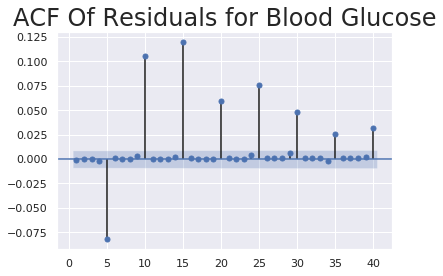

In [220]:
sgt.plot_acf(df_bgtrain.res_price, zero = False, lags = 40)
plt.title("ACF Of Residuals for Blood Glucose",size=24)
plt.show()

Since these residuals are significant, autocorrelation is probably not the best model to use for predicting blood glucose levels.

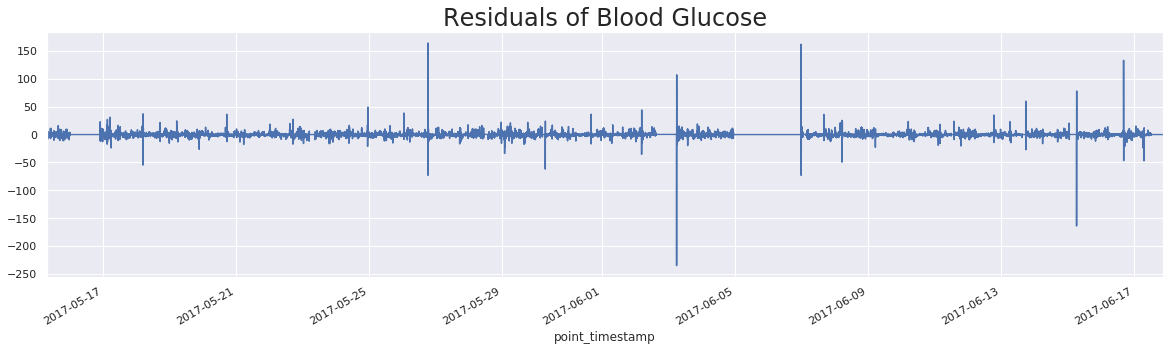

In [221]:
df_bgtrain.res_price[1:].plot(figsize=(20,5))
plt.title("Residuals of Blood Glucose",size=24)
plt.show()

Some extremely large residuals are present - another model, more capable of adjusting to such shocks, would be preferable.

Perhaps moving average might be a better model, as it handles unexpected shocks better.

## MA(1) for Blood Glucose

In [222]:
model_ma_1 = ARMA (df_bg.bg_level[1:], order = (0,1))
results_ma_1 = model_ma_1.fit()
results_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               bg_level   No. Observations:                87838
Model:                     ARMA(0, 1)   Log Likelihood             -447120.052
Method:                       css-mle   S.D. of innovations             39.304
Date:                Fri, 17 Jan 2020   AIC                         894246.104
Time:                        19:08:41   BIC                         894274.254
Sample:                    05-15-2017   HQIC                        894254.697
                         - 07-15-2017                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            162.3375      0.263    617.546      0.000     161.822     162.853
ma.L1.bg_level     0.9822      0.000   2209.302      0.000       0.981       0.983
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.0181           +0.0000j            1.0181            0.5000
-----------------------------------------------------------------------------
"""

Let's see if model_ma_1 performs better than model_ar_11:

In [223]:
model_ar_11 = ARMA(df_bgtrain.bg_level, order=(11,0))
model_ma_1 = ARMA (df_bg.bg_level[1:], order = (0,1))
print("\nLLR test p-value = " + str(LLR_test(model_ar_11, model_ma_1)))


LLR test p-value = 1.0


## ARMA Model

In [224]:
model_ar_1_ma_1 = ARMA(df_bgtrain.bg_level, order = (1,1))
results_ar_1_ma_1 = model_ar_1_ma_1.fit()
results_ar_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               bg_level   No. Observations:                48311
Model:                     ARMA(1, 1)   Log Likelihood             -122075.967
Method:                       css-mle   S.D. of innovations              3.028
Date:                Fri, 17 Jan 2020   AIC                         244159.934
Time:                        19:09:54   BIC                         244195.076
Sample:                    05-15-2017   HQIC                        244170.960
                         - 06-17-2017                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            169.3969     19.734      8.584      0.000     130.720     208.074
ar.L1.bg_level     0.9993      0.000   6134.485      0.000       0.999       1.000
ma.L1.bg_level     0.0003      0.005      0.072      0.942      -0.009       0.009
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0007           +0.0000j            1.0007            0.0000
MA.1        -3035.9043           +0.0000j         3035.9043            0.5000
-----------------------------------------------------------------------------
"""

In [225]:
df_bgtrain['res_ar_1_ma_1'] = results_ar_1_ma_1.resid

In [226]:
round(df_bgtrain.res_ar_1_ma_1.mean(), 3)

0.0

In [227]:
round(df_bgtrain.res_ar_1_ma_1.var(), 3)

9.184

In [228]:
round(sqrt(df_bgtrain.res_ar_1_ma_1.var()), 3)

3.03

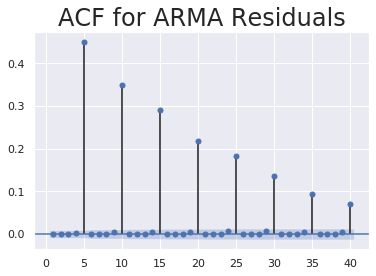

In [229]:
sgt.plot_acf(df_bgtrain.res_ar_1_ma_1, zero = False, lags = 40)
plt.title('ACF for ARMA Residuals', size = 24)
plt.show()

Many of the residuals are significant. For now, let's try accounting for the first significant residual (up to 5 lags).

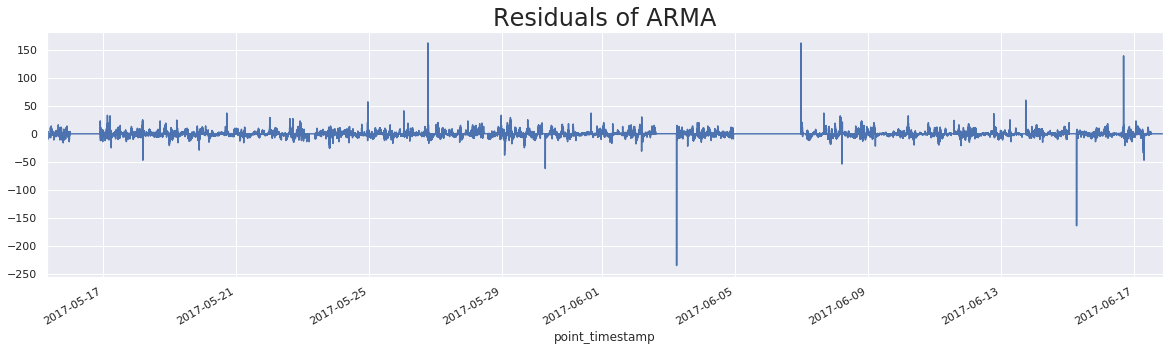

In [230]:
df_bgtrain.res_ar_1_ma_1.plot(figsize = (20, 5))
plt.title('Residuals of ARMA', size = 24)
plt.show()

In [231]:
sts.adfuller(df_bgtrain.res_ar_1_ma_1)

(-29.67172904766557,
 0.0,
 24,
 48286,
 {'1%': -3.4304854356888344,
  '5%': -2.8615998597461596,
  '10%': -2.566801861371292},
 230704.572498251)

In [232]:
model_ar_6_ma_6 = ARMA(df_bgtrain.bg_level, order = (6,6))
results_ar_6_ma_6 = model_ar_6_ma_6.fit()
results_ar_6_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               bg_level   No. Observations:                48311
Model:                     ARMA(6, 6)   Log Likelihood             -115453.132
Method:                       css-mle   S.D. of innovations              2.640
Date:                Fri, 17 Jan 2020   AIC                         230934.263
Time:                        19:11:33   BIC                         231057.259
Sample:                    05-15-2017   HQIC                        230972.853
                         - 06-17-2017                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            170.1053      8.588     19.807      0.000     153.273     186.937
ar.L1.bg_level     1.0041      0.007    151.404      0.000       0.991       1.017
ar.L2.bg_level    -0.0017      0.009     -0.200      0.841      -0.019       0.015
ar.L3.bg_level  -3.84e-05      0.008     -0.005      0.996      -0.015       0.015
ar.L4.bg_level     0.0056      0.008      0.735      0.462      -0.009       0.020
ar.L5.bg_level     0.7831      0.008    103.872      0.000       0.768       0.798
ar.L6.bg_level    -0.7917      0.005   -152.152      0.000      -0.802      -0.782
ma.L1.bg_level    -0.0091      0.008     -1.125      0.261      -0.025       0.007
ma.L2.bg_level    -0.0049      0.008     -0.642      0.521      -0.020       0.010
ma.L3.bg_level    -0.0049      0.008     -0.638      0.524      -0.020       0.010
ma.L4.bg_level    -0.0094      0.008     -1.217      0.224      -0.024       0.006
ma.L5.bg_level    -0.4493      0.008    -59.076      0.000      -0.464      -0.434
ma.L6.bg_level    -0.0017      0.006     -0.296      0.767      -0.013       0.010
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8498           -0.6166j            1.0499           -0.4001
AR.2           -0.8498           +0.6166j            1.0499            0.4001
AR.3            0.3227           -0.9970j            1.0479           -0.2002
AR.4            0.3227           +0.9970j            1.0479            0.2002
AR.5            1.0042           -0.0000j            1.0042           -0.0000
AR.6            1.0390           -0.0000j            1.0390           -0.0000
MA.1            1.1625           -0.0000j            1.1625           -0.0000
MA.2            0.3620           -1.1167j            1.1739           -0.2001
MA.3            0.3620           +1.1167j            1.1739            0.2001
MA.4           -0.9537           -0.6927j            1.1787           -0.4000
MA.5           -0.9537           +0.6927j            1.1787            0.4000
MA.6         -262.7998           -0.0000j          262.7998           -0.5000
-----------------------------------------------------------------------------
"""

Since some of the P values for coefficients are not significant, we should try lowering the number of lags.

In [233]:
model_ar_5_ma_6 = ARMA(df_bgtrain.bg_level, order = (5,6))
results_ar_5_ma_6 = model_ar_5_ma_6.fit()
results_ar_5_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               bg_level   No. Observations:                48311
Model:                     ARMA(5, 6)   Log Likelihood             -117108.590
Method:                       css-mle   S.D. of innovations              2.732
Date:                Fri, 17 Jan 2020   AIC                         234243.181
Time:                        19:13:19   BIC                         234357.391
Sample:                    05-15-2017   HQIC                        234279.014
                         - 06-17-2017                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            170.1054      8.081     21.050      0.000     154.267     185.944
ar.L1.bg_level     1.8565      0.007    251.925      0.000       1.842       1.871
ar.L2.bg_level    -1.2347      0.017    -74.014      0.000      -1.267      -1.202
ar.L3.bg_level     0.2746      0.020     13.660      0.000       0.235       0.314
ar.L4.bg_level     0.6584      0.019     34.710      0.000       0.621       0.696
ar.L5.bg_level    -0.5551      0.009    -64.039      0.000      -0.572      -0.538
ma.L1.bg_level    -0.8941      0.008   -110.169      0.000      -0.910      -0.878
ma.L2.bg_level     0.4048      0.011     37.647      0.000       0.384       0.426
ma.L3.bg_level     0.1323      0.011     11.954      0.000       0.111       0.154
ma.L4.bg_level    -0.5881      0.010    -59.876      0.000      -0.607      -0.569
ma.L5.bg_level     0.3236      0.005     60.416      0.000       0.313       0.334
ma.L6.bg_level    -0.1833      0.005    -37.386      0.000      -0.193      -0.174
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.4961           -0.0000j            1.4961           -0.5000
AR.2            0.3246           -1.0296j            1.0795           -0.2014
AR.3            0.3246           +1.0296j            1.0795            0.2014
AR.4            1.0051           -0.0000j            1.0051           -0.0000
AR.5            1.0279           -0.0000j            1.0279           -0.0000
MA.1           -1.1831           -0.0000j            1.1831           -0.5000
MA.2            1.1085           -0.0000j            1.1085           -0.0000
MA.3            0.1838           -1.3225j            1.3352           -0.2280
MA.4            0.1838           +1.3225j            1.3352            0.2280
MA.5            0.7360           -1.3383j            1.5274           -0.1700
MA.6            0.7360           +1.3383j            1.5274            0.1700
-----------------------------------------------------------------------------
"""

Success!!! The model ar_5_ma_6  contains only significant coefficients.

In [234]:
model_ar_4_ma_6 = ARMA(df_bgtrain.bg_level, order = (4,6))
results_ar_4_ma_6 = model_ar_4_ma_6.fit()
results_ar_4_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               bg_level   No. Observations:                48311
Model:                     ARMA(4, 6)   Log Likelihood             -117479.769
Method:                       css-mle   S.D. of innovations              2.753
Date:                Fri, 17 Jan 2020   AIC                         234983.538
Time:                        19:14:41   BIC                         235088.963
Sample:                    05-15-2017   HQIC                        235016.615
                         - 06-17-2017                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            170.1060     11.229     15.149      0.000     148.097     192.115
ar.L1.bg_level     0.3582      0.010     35.923      0.000       0.339       0.378
ar.L2.bg_level     1.1149      0.007    150.945      0.000       1.100       1.129
ar.L3.bg_level     0.3079      0.008     40.524      0.000       0.293       0.323
ar.L4.bg_level    -0.7818      0.010    -81.205      0.000      -0.801      -0.763
ma.L1.bg_level     0.6707      0.010     64.059      0.000       0.650       0.691
ma.L2.bg_level    -0.4746      0.014    -33.084      0.000      -0.503      -0.446
ma.L3.bg_level    -0.8281      0.012    -67.913      0.000      -0.852      -0.804
ma.L4.bg_level    -0.0494      0.007     -6.869      0.000      -0.063      -0.035
ma.L5.bg_level     0.2732      0.006     47.927      0.000       0.262       0.284
ma.L6.bg_level     0.1847      0.006     33.523      0.000       0.174       0.195
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8668           -0.6188j            1.0650           -0.4013
AR.2           -0.8668           +0.6188j            1.0650            0.4013
AR.3            1.0023           -0.0000j            1.0023           -0.0000
AR.4            1.1251           -0.0000j            1.1251           -0.0000
MA.1            1.2050           -0.3726j            1.2613           -0.0477
MA.2            1.2050           +0.3726j            1.2613            0.0477
MA.3           -1.0570           -0.6307j            1.2308           -0.4144
MA.4           -1.0570           +0.6307j            1.2308            0.4144
MA.5           -0.8878           -1.2077j            1.4990           -0.3509
MA.6           -0.8878           +1.2077j            1.4990            0.3509
-----------------------------------------------------------------------------
"""

Success!!! The model ar_4_ma_6  contains only significant coefficients.

In [235]:
model_ar_3_ma_6 = ARMA(df_bgtrain.bg_level, order = (3,6))
results_ar_3_ma_6 = model_ar_3_ma_6.fit()
results_ar_3_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               bg_level   No. Observations:                48311
Model:                     ARMA(3, 6)   Log Likelihood             -117758.360
Method:                       css-mle   S.D. of innovations              2.769
Date:                Fri, 17 Jan 2020   AIC                         235538.720
Time:                        19:16:31   BIC                         235635.359
Sample:                    05-15-2017   HQIC                        235569.040
                         - 06-17-2017                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            168.6554      7.878     21.409      0.000     153.216     184.095
ar.L1.bg_level     1.8343      0.002    749.258      0.000       1.829       1.839
ar.L2.bg_level    -0.6996      0.005   -140.830      0.000      -0.709      -0.690
ar.L3.bg_level    -0.1348      0.003    -45.101      0.000      -0.141      -0.129
ma.L1.bg_level    -0.8558      0.005   -174.345      0.000      -0.865      -0.846
ma.L2.bg_level    -0.1259      0.006    -20.046      0.000      -0.138      -0.114
ma.L3.bg_level    -0.0047      0.005     -0.864      0.388      -0.015       0.006
ma.L4.bg_level     0.0120      0.006      2.125      0.034       0.001       0.023
ma.L5.bg_level     0.3422      0.005     65.486      0.000       0.332       0.352
ma.L6.bg_level    -0.2810      0.004    -66.779      0.000      -0.289      -0.273
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0057           +0.0000j            1.0057            0.0000
AR.2            1.0220           +0.0000j            1.0220            0.0000
AR.3           -7.2183           +0.0000j            7.2183            0.5000
MA.1           -1.2252           -0.0000j            1.2252           -0.5000
MA.2           -0.4128           -1.1807j            1.2507           -0.3035
MA.3           -0.4128           +1.1807j            1.2507            0.3035
MA.4            1.0769           -0.0000j            1.0769           -0.0000
MA.5            1.0957           -0.7235j            1.3130           -0.0929
MA.6            1.0957           +0.7235j            1.3130            0.0929
-----------------------------------------------------------------------------
"""

In [236]:
model_ar_2_ma_6 = ARMA(df_bgtrain.bg_level, order = (2,6))
results_ar_2_ma_6 = model_ar_2_ma_6.fit()
results_ar_2_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               bg_level   No. Observations:                48311
Model:                     ARMA(2, 6)   Log Likelihood             -118259.553
Method:                       css-mle   S.D. of innovations              2.798
Date:                Fri, 17 Jan 2020   AIC                         236539.106
Time:                        19:17:47   BIC                         236626.960
Sample:                    05-15-2017   HQIC                        236566.670
                         - 06-17-2017                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            170.1053     16.253     10.466      0.000     138.250     201.960
ar.L1.bg_level     1.0316      0.162      6.350      0.000       0.713       1.350
ar.L2.bg_level    -0.0326      0.162     -0.201      0.841      -0.351       0.285
ma.L1.bg_level    -0.0331      0.162     -0.204      0.839      -0.352       0.285
ma.L2.bg_level     0.0004      0.004      0.092      0.927      -0.008       0.009
ma.L3.bg_level     0.0004      0.004      0.084      0.933      -0.008       0.009
ma.L4.bg_level     0.0013      0.005      0.280      0.780      -0.008       0.010
ma.L5.bg_level     0.3403      0.004     92.273      0.000       0.333       0.348
ma.L6.bg_level    -0.0107      0.055     -0.192      0.848      -0.119       0.098
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0010           +0.0000j            1.0010            0.0000
AR.2           30.6130           +0.0000j           30.6130            0.0000
MA.1           -1.2418           -0.0000j            1.2418           -0.5000
MA.2           -0.3835           -1.1802j            1.2410           -0.3000
MA.3           -0.3835           +1.1802j            1.2410            0.3000
MA.4            1.0025           -0.7289j            1.2395           -0.1001
MA.5            1.0025           +0.7289j            1.2395            0.1001
MA.6           31.9569           -0.0000j           31.9569           -0.0000
-----------------------------------------------------------------------------
"""

In [237]:
model_ar_1_ma_6 = ARMA(df_bgtrain.bg_level, order = (1,6))
results_ar_1_ma_6 = model_ar_1_ma_6.fit()
results_ar_1_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               bg_level   No. Observations:                48311
Model:                     ARMA(1, 6)   Log Likelihood             -118259.553
Method:                       css-mle   S.D. of innovations              2.798
Date:                Fri, 17 Jan 2020   AIC                         236537.107
Time:                        19:18:47   BIC                         236616.175
Sample:                    05-15-2017   HQIC                        236561.914
                         - 06-17-2017                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            170.1052     16.254     10.466      0.000     138.248     201.962
ar.L1.bg_level     0.9990      0.000   4912.603      0.000       0.999       0.999
ma.L1.bg_level    -0.0004      0.005     -0.095      0.924      -0.009       0.008
ma.L2.bg_level     0.0004      0.004      0.088      0.930      -0.008       0.009
ma.L3.bg_level     0.0004      0.004      0.087      0.930      -0.008       0.009
ma.L4.bg_level     0.0013      0.005      0.284      0.777      -0.008       0.010
ma.L5.bg_level     0.3404      0.004     92.527      0.000       0.333       0.348
ma.L6.bg_level     0.0005      0.005      0.094      0.925      -0.009       0.010
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0010           +0.0000j            1.0010            0.0000
MA.1            1.0025           -0.7289j            1.2395           -0.1001
MA.2            1.0025           +0.7289j            1.2395            0.1001
MA.3           -0.3835           -1.1802j            1.2410           -0.3000
MA.4           -0.3835           +1.1802j            1.2410            0.3000
MA.5           -1.2418           -0.0000j            1.2418           -0.5000
MA.6         -750.8867           -0.0000j          750.8867           -0.5000
-----------------------------------------------------------------------------
"""

In [238]:
model_ar_6_ma_5 = ARMA(df_bgtrain.bg_level, order = (6,5))
results_ar_6_ma_5 = model_ar_6_ma_5.fit()
results_ar_6_ma_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               bg_level   No. Observations:                48311
Model:                     ARMA(6, 5)   Log Likelihood             -115453.175
Method:                       css-mle   S.D. of innovations              2.640
Date:                Fri, 17 Jan 2020   AIC                         230932.351
Time:                        19:20:11   BIC                         231046.561
Sample:                    05-15-2017   HQIC                        230968.184
                         - 06-17-2017                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            170.1053      8.600     19.780      0.000     153.250     186.961
ar.L1.bg_level     1.0029      0.005    191.856      0.000       0.993       1.013
ar.L2.bg_level    -0.0005      0.008     -0.066      0.947      -0.015       0.014
ar.L3.bg_level -5.469e-05      0.008     -0.007      0.994      -0.015       0.015
ar.L4.bg_level     0.0056      0.008      0.740      0.459      -0.009       0.020
ar.L5.bg_level     0.7831      0.008    104.076      0.000       0.768       0.798
ar.L6.bg_level    -0.7918      0.005   -152.266      0.000      -0.802      -0.782
ma.L1.bg_level    -0.0083      0.008     -1.086      0.277      -0.023       0.007
ma.L2.bg_level    -0.0050      0.008     -0.646      0.518      -0.020       0.010
ma.L3.bg_level    -0.0049      0.008     -0.637      0.524      -0.020       0.010
ma.L4.bg_level    -0.0094      0.008     -1.225      0.221      -0.024       0.006
ma.L5.bg_level    -0.4494      0.008    -59.107      0.000      -0.464      -0.434
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8497           -0.6163j            1.0497           -0.4001
AR.2           -0.8497           +0.6163j            1.0497            0.4001
AR.3            0.3225           -0.9971j            1.0480           -0.2002
AR.4            0.3225           +0.9971j            1.0480            0.2002
AR.5            1.0042           -0.0000j            1.0042           -0.0000
AR.6            1.0393           -0.0000j            1.0393           -0.0000
MA.1            1.1636           -0.0000j            1.1636           -0.0000
MA.2            0.3610           -1.1174j            1.1743           -0.2003
MA.3            0.3610           +1.1174j            1.1743            0.2003
MA.4           -0.9533           -0.6915j            1.1777           -0.4001
MA.5           -0.9533           +0.6915j            1.1777            0.4001
-----------------------------------------------------------------------------
"""

In [239]:
model_ar_6_ma_4 = ARMA(df_bgtrain.bg_level, order = (6,4))
results_ar_6_ma_4 = model_ar_6_ma_4.fit()
results_ar_6_ma_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               bg_level   No. Observations:                48311
Model:                     ARMA(6, 4)   Log Likelihood             -116559.111
Method:                       css-mle   S.D. of innovations              2.701
Date:                Fri, 17 Jan 2020   AIC                         233142.221
Time:                        19:21:52   BIC                         233247.646
Sample:                    05-15-2017   HQIC                        233175.298
                         - 06-17-2017                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            170.1053     11.979     14.200      0.000     146.627     193.583
ar.L1.bg_level     1.0275      0.014     73.071      0.000       1.000       1.055
ar.L2.bg_level    -0.0215      0.021     -1.021      0.307      -0.063       0.020
ar.L3.bg_level    -0.0001      0.011     -0.014      0.989      -0.021       0.021
ar.L4.bg_level     0.0283      0.021      1.337      0.181      -0.013       0.070
ar.L5.bg_level     0.4161      0.015     27.481      0.000       0.386       0.446
ar.L6.bg_level    -0.4511      0.004   -110.316      0.000      -0.459      -0.443
ma.L1.bg_level    -0.0370      0.017     -2.184      0.029      -0.070      -0.004
ma.L2.bg_level    -0.0085      0.016     -0.526      0.599      -0.040       0.023
ma.L3.bg_level    -0.0083      0.016     -0.503      0.615      -0.041       0.024
ma.L4.bg_level    -0.0397      0.017     -2.341      0.019      -0.073      -0.006
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.9655           -0.6957j            1.1900           -0.4006
AR.2           -0.9655           +0.6957j            1.1900            0.4006
AR.3            0.3540           -1.1140j            1.1689           -0.2010
AR.4            0.3540           +1.1140j            1.1689            0.2010
AR.5            1.0020           -0.0000j            1.0020           -0.0000
AR.6            1.1433           -0.0000j            1.1433           -0.0000
MA.1           -2.3157           -0.0000j            2.3157           -0.5000
MA.2            2.1208           -0.0000j            2.1208           -0.0000
MA.3           -0.0069           -2.2633j            2.2633           -0.2505
MA.4           -0.0069           +2.2633j            2.2633            0.2505
-----------------------------------------------------------------------------
"""

In [240]:
model_ar_6_ma_3 = ARMA(df_bgtrain.bg_level, order = (6, 3))
results_ar_6_ma_3 = model_ar_6_ma_3.fit()
results_ar_6_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               bg_level   No. Observations:                48311
Model:                     ARMA(6, 3)   Log Likelihood             -116561.846
Method:                       css-mle   S.D. of innovations              2.701
Date:                Fri, 17 Jan 2020   AIC                         233145.692
Time:                        19:23:14   BIC                         233242.331
Sample:                    05-15-2017   HQIC                        233176.012
                         - 06-17-2017                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            170.1052     12.361     13.762      0.000     145.879     194.332
ar.L1.bg_level     1.0023      0.009    111.336      0.000       0.985       1.020
ar.L2.bg_level     0.0060      0.017      0.351      0.725      -0.028       0.040
ar.L3.bg_level -1.755e-05      0.010     -0.002      0.999      -0.020       0.020
ar.L4.bg_level    -0.0057      0.015     -0.379      0.705      -0.035       0.024
ar.L5.bg_level     0.4482      0.006     77.880      0.000       0.437       0.459
ar.L6.bg_level    -0.4517      0.004   -111.208      0.000      -0.460      -0.444
ma.L1.bg_level    -0.0052      0.010     -0.519      0.604      -0.025       0.015
ma.L2.bg_level    -0.0110      0.018     -0.628      0.530      -0.045       0.023
ma.L3.bg_level    -0.0110      0.017     -0.631      0.528      -0.045       0.023
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.9483           -0.6890j            1.1722           -0.4000
AR.2           -0.9483           +0.6890j            1.1722            0.4000
AR.3            0.3625           -1.1194j            1.1766           -0.2001
AR.4            0.3625           +1.1194j            1.1766            0.2001
AR.5            1.0018           -0.0000j            1.0018           -0.0000
AR.6            1.1618           -0.0000j            1.1618           -0.0000
MA.1            4.1544           -0.0000j            4.1544           -0.0000
MA.2           -2.5796           -3.9059j            4.6809           -0.3429
MA.3           -2.5796           +3.9059j            4.6809            0.3429
-----------------------------------------------------------------------------
"""

In [241]:
model_ar_6_ma_2 = ARMA(df_bgtrain.bg_level, order = (6,2))
results_ar_6_ma_2 = model_ar_6_ma_2.fit()
results_ar_6_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               bg_level   No. Observations:                48311
Model:                     ARMA(6, 2)   Log Likelihood             -116562.045
Method:                       css-mle   S.D. of innovations              2.701
Date:                Fri, 17 Jan 2020   AIC                         233144.090
Time:                        19:24:22   BIC                         233231.944
Sample:                    05-15-2017   HQIC                        233171.654
                         - 06-17-2017                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            170.1052     12.473     13.638      0.000     145.659     194.551
ar.L1.bg_level     1.0022      0.009    111.708      0.000       0.985       1.020
ar.L2.bg_level    -0.0010      0.013     -0.082      0.935      -0.026       0.024
ar.L3.bg_level    -0.0016      0.010     -0.161      0.872      -0.021       0.018
ar.L4.bg_level     0.0031      0.006      0.531      0.595      -0.008       0.014
ar.L5.bg_level     0.4482      0.006     77.893      0.000       0.437       0.459
ar.L6.bg_level    -0.4517      0.004   -111.289      0.000      -0.460      -0.444
ma.L1.bg_level    -0.0051      0.010     -0.505      0.613      -0.025       0.015
ma.L2.bg_level    -0.0020      0.010     -0.197      0.844      -0.022       0.018
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.9502           -0.6892j            1.1739           -0.4001
AR.2           -0.9502           +0.6892j            1.1739            0.4001
AR.3            0.3617           -1.1149j            1.1721           -0.2001
AR.4            0.3617           +1.1149j            1.1721            0.2001
AR.5            1.0018           -0.0000j            1.0018           -0.0000
AR.6            1.1674           -0.0000j            1.1674           -0.0000
MA.1           21.0275           +0.0000j           21.0275            0.0000
MA.2          -23.5432           +0.0000j           23.5432            0.5000
-----------------------------------------------------------------------------
"""

In [242]:
model_ar_6_ma_1 = ARMA(df_bgtrain.bg_level, order = (6,1))
results_ar_6_ma_1 = model_ar_6_ma_1.fit()
results_ar_6_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               bg_level   No. Observations:                48311
Model:                     ARMA(6, 1)   Log Likelihood             -116562.064
Method:                       css-mle   S.D. of innovations              2.701
Date:                Fri, 17 Jan 2020   AIC                         233142.129
Time:                        19:25:19   BIC                         233221.197
Sample:                    05-15-2017   HQIC                        233166.936
                         - 06-17-2017                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            170.1052     12.484     13.626      0.000     145.637     194.573
ar.L1.bg_level     1.0022      0.009    111.542      0.000       0.985       1.020
ar.L2.bg_level    -0.0027      0.010     -0.271      0.786      -0.022       0.017
ar.L3.bg_level -9.606e-09      0.006  -1.67e-06      1.000      -0.011       0.011
ar.L4.bg_level     0.0031      0.006      0.532      0.595      -0.008       0.014
ar.L5.bg_level     0.4482      0.006     77.892      0.000       0.437       0.459
ar.L6.bg_level    -0.4517      0.004   -111.289      0.000      -0.460      -0.444
ma.L1.bg_level    -0.0051      0.010     -0.506      0.613      -0.025       0.015
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.9500           -0.6897j            1.1740           -0.4001
AR.2           -0.9500           +0.6897j            1.1740            0.4001
AR.3            0.3613           -1.1146j            1.1717           -0.2001
AR.4            0.3613           +1.1146j            1.1717            0.2001
AR.5            1.0018           -0.0000j            1.0018           -0.0000
AR.6            1.1679           -0.0000j            1.1679           -0.0000
MA.1          196.1357           +0.0000j          196.1357            0.0000
-----------------------------------------------------------------------------
"""

In [243]:
print("ARMA(5,6): \t LL = ", results_ar_5_ma_6.llf, "\t AIC = ", results_ar_5_ma_6.aic)
print("ARMA(4,6): \t LL = ", results_ar_4_ma_6.llf, "\t AIC = ", results_ar_4_ma_6.aic)

ARMA(5,6): 	 LL =  -117108.5903131568 	 AIC =  234243.1806263136
ARMA(4,6): 	 LL =  -117479.76904276272 	 AIC =  234983.53808552545


ARMA(5,6) has a higher Log likelihood, as well as a lower AIC. Therefore, ARMA(5,6) is our preferred model.

In [244]:
df_bgtrain['res_ar_5_ma_6'] = results_ar_5_ma_6.resid

In [245]:
round(df_bgtrain.res_ar_5_ma_6.mean(), 3)

-0.0

In [246]:
round(df_bgtrain.res_ar_5_ma_6.var(), 3)

7.48

In [247]:
round(sqrt(df_bgtrain.res_ar_5_ma_6.var()), 3)

2.735

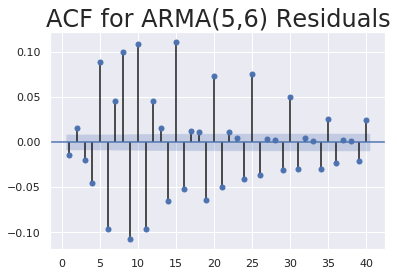

In [248]:
sgt.plot_acf(df_bgtrain.res_ar_5_ma_6, zero = False, lags = 40)
plt.title('ACF for ARMA(5,6) Residuals', size = 24)
plt.show()

Many of the residuals are still significant. The residuals do not resemble white noise. This is not an especially great model.

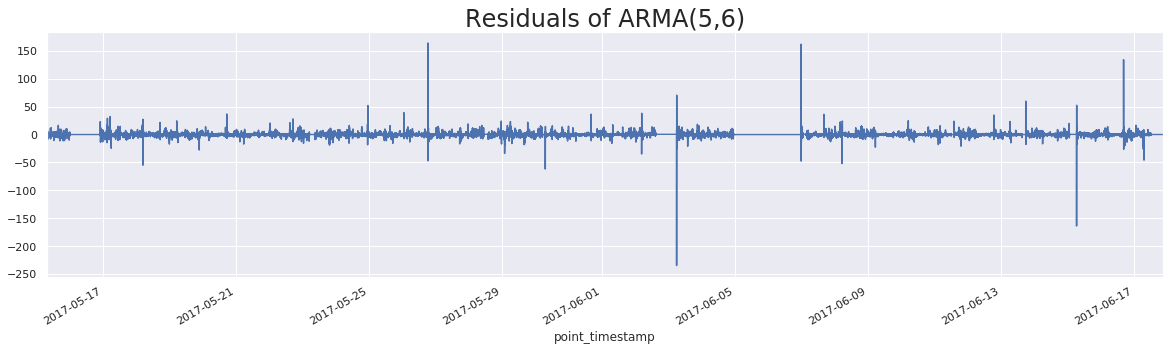

In [249]:
df_bgtrain.res_ar_5_ma_6.plot(figsize = (20, 5))
plt.title('Residuals of ARMA(5,6)', size = 24)
plt.show()

In [250]:
sts.adfuller(df_bgtrain.res_ar_5_ma_6)

(-34.35220291197095,
 0.0,
 44,
 48266,
 {'1%': -3.4304854918123553,
  '5%': -2.8615998845510173,
  '10%': -2.5668018745741996},
 230643.88674841175)

In [251]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

## ARIMA

Let's start with ARIMA(1, 1, 1).

In [252]:
model_ar_1_i_1_ma_1 = ARIMA(df_bgtrain.bg_level, order=(1,1,1))
results_ar_1_i_1_ma_1 = model_ar_1_i_1_ma_1.fit()
results_ar_1_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:             D.bg_level   No. Observations:                48310
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -122078.555
Method:                       css-mle   S.D. of innovations              3.028
Date:                Fri, 17 Jan 2020   AIC                         244165.110
Time:                        19:26:01   BIC                         244200.251
Sample:                    05-15-2017   HQIC                        244176.135
                         - 06-17-2017                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0002      0.014      0.015      0.988      -0.027       0.027
ar.L1.D.bg_level     0.0110        nan        nan        nan         nan         nan
ma.L1.D.bg_level    -0.0110        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           90.5773           +0.0000j           90.5773            0.0000
MA.1           90.5772           +0.0000j           90.5772            0.0000
-----------------------------------------------------------------------------
"""

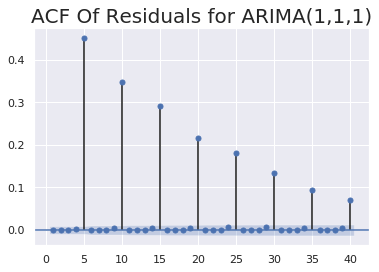

In [253]:
df_bgtrain['res_ar_1_i_1_ma_1'] = results_ar_1_i_1_ma_1.resid
sgt.plot_acf(df_bgtrain.res_ar_1_i_1_ma_1[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(1,1,1)",size=20)
plt.show()

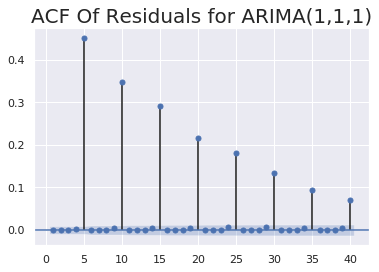

In [254]:
df_bgtrain['res_ar_1_i_1_ma_1'] = results_ar_1_i_1_ma_1.resid.iloc[:]
sgt.plot_acf(df_bgtrain.res_ar_1_i_1_ma_1[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(1,1,1)",size=20)
plt.show()

There is a strong peak for lag-5. Let's try some higher lag ARIMA models!

In [255]:
model_ar_1_i_1_ma_2 = ARIMA(df_bgtrain.bg_level, order=(1,1,2))
results_ar_1_i_1_ma_2 = model_ar_1_i_1_ma_2.fit()
model_ar_1_i_1_ma_3 = ARIMA(df_bgtrain.bg_level, order=(1,1,3))
results_ar_1_i_1_ma_3 = model_ar_1_i_1_ma_3.fit()
model_ar_1_i_1_ma_4 = ARIMA(df_bgtrain.bg_level, order=(1,1,4))
results_ar_1_i_1_ma_4 = model_ar_1_i_1_ma_4.fit()
model_ar_1_i_1_ma_5 = ARIMA(df_bgtrain.bg_level, order=(1,1,5))
results_ar_1_i_1_ma_5 = model_ar_1_i_1_ma_5.fit()
model_ar_2_i_1_ma_1 = ARIMA(df_bgtrain.bg_level, order=(2,1,1))
results_ar_2_i_1_ma_1 = model_ar_2_i_1_ma_1.fit()
model_ar_3_i_1_ma_1 = ARIMA(df_bgtrain.bg_level, order=(3,1,1))
results_ar_3_i_1_ma_1 = model_ar_3_i_1_ma_1.fit()
model_ar_4_i_1_ma_1 = ARIMA(df_bgtrain.bg_level, order=(4,1,1))
results_ar_4_i_1_ma_1 = model_ar_4_i_1_ma_1.fit()
model_ar_5_i_1_ma_1 = ARIMA(df_bgtrain.bg_level, order=(5,1,1))
results_ar_5_i_1_ma_1 = model_ar_5_i_1_ma_1.fit()
model_ar_2_i_1_ma_2 = ARIMA(df_bgtrain.bg_level, order=(2,1,2))
results_ar_2_i_1_ma_2 = model_ar_2_i_1_ma_2.fit()

In [256]:
model_ar_2_i_1_ma_3 = ARIMA(df_bgtrain.bg_level, order=(2,1,3))
results_ar_2_i_1_ma_3 = model_ar_2_i_1_ma_3.fit()
model_ar_2_i_1_ma_4 = ARIMA(df_bgtrain.bg_level, order=(2,1,4))
results_ar_2_i_1_ma_4 = model_ar_2_i_1_ma_4.fit()
model_ar_2_i_1_ma_5 = ARIMA(df_bgtrain.bg_level, order=(2,1,5))
results_ar_2_i_1_ma_5 = model_ar_2_i_1_ma_5.fit()
model_ar_3_i_1_ma_2 = ARIMA(df_bgtrain.bg_level, order=(3,1,2))
results_ar_3_i_1_ma_2 = model_ar_3_i_1_ma_2.fit()
model_ar_3_i_1_ma_3 = ARIMA(df_bgtrain.bg_level, order=(3,1,3))
results_ar_3_i_1_ma_3 = model_ar_3_i_1_ma_3.fit()
model_ar_3_i_1_ma_4 = ARIMA(df_bgtrain.bg_level, order=(3,1,4))
results_ar_3_i_1_ma_4 = model_ar_3_i_1_ma_4.fit()

In [257]:
model_ar_3_i_1_ma_5 = ARIMA(df_bgtrain.bg_level, order=(3,1,5))
results_ar_3_i_1_ma_5 = model_ar_3_i_1_ma_5.fit()
model_ar_4_i_1_ma_2 = ARIMA(df_bgtrain.bg_level, order=(4,1,2))
results_ar_4_i_1_ma_2 = model_ar_4_i_1_ma_2.fit()
model_ar_4_i_1_ma_3 = ARIMA(df_bgtrain.bg_level, order=(4,1,3))
results_ar_4_i_1_ma_3 = model_ar_4_i_1_ma_3.fit()
model_ar_4_i_1_ma_4 = ARIMA(df_bgtrain.bg_level, order=(4,1,4))
results_ar_4_i_1_ma_4 = model_ar_4_i_1_ma_4.fit()
model_ar_4_i_1_ma_5 = ARIMA(df_bgtrain.bg_level, order=(4,1,5))
results_ar_4_i_1_ma_5 = model_ar_4_i_1_ma_5.fit()

In [258]:
model_ar_5_i_1_ma_2 = ARIMA(df_bgtrain.bg_level, order=(5,1,2))
results_ar_5_i_1_ma_2 = model_ar_5_i_1_ma_2.fit()
model_ar_5_i_1_ma_3 = ARIMA(df_bgtrain.bg_level, order=(5,1,3))
results_ar_5_i_1_ma_3 = model_ar_5_i_1_ma_3.fit()
model_ar_5_i_1_ma_4 = ARIMA(df_bgtrain.bg_level, order=(5,1,4))
results_ar_5_i_1_ma_4 = model_ar_5_i_1_ma_4.fit()
model_ar_5_i_1_ma_5 = ARIMA(df_bgtrain.bg_level, order=(5,1,5))
results_ar_5_i_1_ma_5 = model_ar_5_i_1_ma_5.fit()

In [259]:
print("ARIMA(1,1,1):  \t LL = ", results_ar_1_i_1_ma_1.llf, "\t AIC = ", results_ar_1_i_1_ma_1.aic)
print("ARIMA(1,1,2):  \t LL = ", results_ar_1_i_1_ma_2.llf, "\t AIC = ", results_ar_1_i_1_ma_2.aic)
print("ARIMA(1,1,3):  \t LL = ", results_ar_1_i_1_ma_3.llf, "\t AIC = ", results_ar_1_i_1_ma_3.aic)
print("ARIMA(1,1,4):  \t LL = ", results_ar_1_i_1_ma_4.llf, "\t AIC = ", results_ar_1_i_1_ma_4.aic)
print("ARIMA(1,1,5):  \t LL = ", results_ar_1_i_1_ma_5.llf, "\t AIC = ", results_ar_1_i_1_ma_5.aic)
print("ARIMA(2,1,1):  \t LL = ", results_ar_2_i_1_ma_1.llf, "\t AIC = ", results_ar_2_i_1_ma_1.aic)
print("ARIMA(3,1,1):  \t LL = ", results_ar_3_i_1_ma_1.llf, "\t AIC = ", results_ar_3_i_1_ma_1.aic)
print("ARIMA(4,1,1):  \t LL = ", results_ar_4_i_1_ma_1.llf, "\t AIC = ", results_ar_4_i_1_ma_1.aic)
print("ARIMA(5,1,1):  \t LL = ", results_ar_5_i_1_ma_1.llf, "\t AIC = ", results_ar_5_i_1_ma_1.aic)
print("ARIMA(2,1,2):  \t LL = ", results_ar_2_i_1_ma_2.llf, "\t AIC = ", results_ar_2_i_1_ma_2.aic)
print("ARIMA(3,1,2):  \t LL = ", results_ar_3_i_1_ma_2.llf, "\t AIC = ", results_ar_3_i_1_ma_2.aic)
print("ARIMA(4,1,2):  \t LL = ", results_ar_4_i_1_ma_2.llf, "\t AIC = ", results_ar_4_i_1_ma_2.aic)
print("ARIMA(5,1,2):  \t LL = ", results_ar_5_i_1_ma_2.llf, "\t AIC = ", results_ar_5_i_1_ma_2.aic)
print("ARIMA(3,1,2):  \t LL = ", results_ar_3_i_1_ma_2.llf, "\t AIC = ", results_ar_3_i_1_ma_2.aic)
print("ARIMA(3,1,3):  \t LL = ", results_ar_3_i_1_ma_3.llf, "\t AIC = ", results_ar_3_i_1_ma_3.aic)
print("ARIMA(3,1,4):  \t LL = ", results_ar_3_i_1_ma_4.llf, "\t AIC = ", results_ar_3_i_1_ma_4.aic)
print("ARIMA(3,1,5):  \t LL = ", results_ar_3_i_1_ma_5.llf, "\t AIC = ", results_ar_3_i_1_ma_5.aic)
print("ARIMA(4,1,2):  \t LL = ", results_ar_4_i_1_ma_2.llf, "\t AIC = ", results_ar_4_i_1_ma_2.aic)
print("ARIMA(4,1,3):  \t LL = ", results_ar_4_i_1_ma_3.llf, "\t AIC = ", results_ar_4_i_1_ma_3.aic)
print("ARIMA(4,1,4):  \t LL = ", results_ar_4_i_1_ma_4.llf, "\t AIC = ", results_ar_4_i_1_ma_4.aic)
print("ARIMA(4,1,5):  \t LL = ", results_ar_4_i_1_ma_5.llf, "\t AIC = ", results_ar_4_i_1_ma_5.aic)
print("ARIMA(5,1,2):  \t LL = ", results_ar_5_i_1_ma_2.llf, "\t AIC = ", results_ar_5_i_1_ma_2.aic)
print("ARIMA(5,1,3):  \t LL = ", results_ar_5_i_1_ma_3.llf, "\t AIC = ", results_ar_5_i_1_ma_3.aic)
print("ARIMA(5,1,4):  \t LL = ", results_ar_5_i_1_ma_4.llf, "\t AIC = ", results_ar_5_i_1_ma_4.aic)
print("ARIMA(5,1,5):  \t LL = ", results_ar_5_i_1_ma_5.llf, "\t AIC = ", results_ar_5_i_1_ma_5.aic)




ARIMA(1,1,1):  	 LL =  -122078.5548720728 	 AIC =  244165.1097441456
ARIMA(1,1,2):  	 LL =  -122078.55487205042 	 AIC =  244167.10974410083
ARIMA(1,1,3):  	 LL =  -120601.01972186842 	 AIC =  241214.03944373684
ARIMA(1,1,4):  	 LL =  -120402.93228991018 	 AIC =  240819.86457982037
ARIMA(1,1,5):  	 LL =  -118266.38252593545 	 AIC =  236548.7650518709
ARIMA(2,1,1):  	 LL =  -122078.55487204995 	 AIC =  244167.1097440999
ARIMA(3,1,1):  	 LL =  -120873.8493575548 	 AIC =  241759.6987151096
ARIMA(4,1,1):  	 LL =  -120378.57309022252 	 AIC =  240771.14618044504
ARIMA(5,1,1):  	 LL =  -116577.98578367292 	 AIC =  233171.97156734584
ARIMA(2,1,2):  	 LL =  -122078.55487207015 	 AIC =  244169.1097441403
ARIMA(3,1,2):  	 LL =  -120491.40128930245 	 AIC =  240996.8025786049
ARIMA(4,1,2):  	 LL =  -119569.09870688037 	 AIC =  239154.19741376073
ARIMA(5,1,2):  	 LL =  -116577.98578366138 	 AIC =  233173.97156732276
ARIMA(3,1,2):  	 LL =  -120491.40128930245 	 AIC =  240996.8025786049
ARIMA(3,1,3):  

ARIMA(5,1,5) has the highest LL and the lowest AIC, so we will select ARIMA(5,1,5).

In [260]:
model_ar_1_i_1_ma_1 = ARIMA(df_bgtrain.bg_level, order=(1,1,1))
model_ar_5_i_1_ma_5 = ARIMA(df_bgtrain.bg_level, order=(5,1,5))
print("\nLLR test p-value = " + str(LLR_test(results_ar_1_i_1_ma_1, results_ar_5_i_1_ma_5, DF = 8)))


LLR test p-value = 0.0


The added comlexity is worth it, since the LLR test returned a p value of 0.0 (significant).

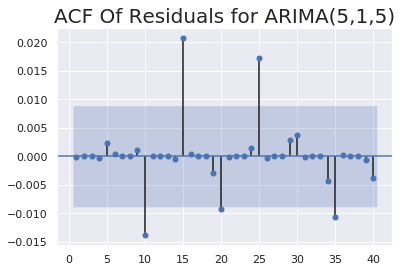

In [261]:
df_bgtrain['res_ar_5_i_1_ma_5'] = results_ar_5_i_1_ma_5.resid
sgt.plot_acf(df_bgtrain.res_ar_5_i_1_ma_5[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(5,1,5)", size=20)
plt.show()

These residuals look better - the lag-5 residual is no longer significant. However, there are still other significant residuals, such as the 10th residual.

In [262]:
results_ar_5_i_1_ma_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:             D.bg_level   No. Observations:                48310
Model:                 ARIMA(5, 1, 5)   Log Likelihood             -115492.339
Method:                       css-mle   S.D. of innovations              2.642
Date:                Fri, 17 Jan 2020   AIC                         231008.677
Time:                        19:32:43   BIC                         231114.102
Sample:                    05-15-2017   HQIC                        231041.754
                         - 06-17-2017                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0001      0.032      0.004      0.997      -0.063       0.063
ar.L1.D.bg_level     0.0005      0.005      0.100      0.920      -0.010       0.011
ar.L2.D.bg_level  -5.56e-06      0.005     -0.001      0.999      -0.010       0.010
ar.L3.D.bg_level -7.838e-05      0.005     -0.015      0.988      -0.010       0.010
ar.L4.D.bg_level     0.0055      0.005      1.039      0.299      -0.005       0.016
ar.L5.D.bg_level     0.7886      0.005    150.483      0.000       0.778       0.799
ma.L1.D.bg_level    -0.0034      0.008     -0.441      0.659      -0.018       0.012
ma.L2.D.bg_level  1.258e-05      0.008      0.002      0.999      -0.015       0.015
ma.L3.D.bg_level  9.815e-05      0.008      0.013      0.990      -0.015       0.015
ma.L4.D.bg_level    -0.0044      0.008     -0.572      0.567      -0.019       0.011
ma.L5.D.bg_level    -0.4444      0.008    -58.379      0.000      -0.459      -0.429
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0472           -0.0000j            1.0472           -0.0000
AR.2            0.3228           -0.9972j            1.0482           -0.2002
AR.3            0.3228           +0.9972j            1.0482            0.2002
AR.4           -0.8498           -0.6165j            1.0499           -0.4001
AR.5           -0.8498           +0.6165j            1.0499            0.4001
MA.1            1.1733           -0.0000j            1.1733           -0.0000
MA.2            0.3622           -1.1180j            1.1752           -0.2001
MA.3            0.3622           +1.1180j            1.1752            0.2001
MA.4           -0.9538           -0.6922j            1.1785           -0.4001
MA.5           -0.9538           +0.6922j            1.1785            0.4001
-----------------------------------------------------------------------------
"""

Check if one order of integration is enough:

In [263]:
df_bgtrain['delta_prices']= df_bgtrain.bg_level.diff(1)

In [264]:
sts.adfuller(df_bgtrain.delta_prices[1:])

(-29.71616950627392,
 0.0,
 24,
 48285,
 {'1%': -3.430485438493906,
  '5%': -2.861599860985914,
  '10%': -2.566801862031178},
 230730.2398247855)

## ARIMAX

In [265]:
df_da_synced_train.head()

,point_timestamp,distance,heartrate
0,2017-05-16 22:15:44,0.0,98.0
1,2017-05-16 22:16:44,0.0,104.0
2,2017-05-16 22:17:44,0.0,110.0
3,2017-05-16 22:18:44,0.0,112.0
4,2017-05-16 22:19:44,0.0,97.0


In [266]:
model_ar_5_i_1_ma_5_Xhr_Xda = ARIMA(df_bg_synced_train.bg_level, exog = df_da_synced_train[['distance', 'heartrate']], order=(5,1,5))
results_ar_5_i_1_ma_5_Xhr_Xda = model_ar_5_i_1_ma_5_Xhr_Xda.fit()
results_ar_5_i_1_ma_5_Xhr_Xda.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:             D.bg_level   No. Observations:                46569
Model:                 ARIMA(5, 1, 5)   Log Likelihood             -111903.688
Method:                       css-mle   S.D. of innovations              2.675
Date:                Fri, 17 Jan 2020   AIC                         223835.377
Time:                        19:34:12   BIC                         223957.858
Sample:                             1   HQIC                        223873.871
                                                                              
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2669      0.133      2.012      0.044       0.007       0.527
distance            -0.2317      0.741     -0.313      0.754      -1.684       1.221
heartrate           -0.0030      0.001     -2.060      0.039      -0.006      -0.000
ar.L1.D.bg_level     0.0007      0.005      0.125      0.900      -0.010       0.011
ar.L2.D.bg_level     0.0003      0.005      0.062      0.950      -0.010       0.011
ar.L3.D.bg_level     0.0003      0.005      0.064      0.949      -0.010       0.011
ar.L4.D.bg_level     0.0060      0.005      1.118      0.263      -0.005       0.016
ar.L5.D.bg_level     0.7920      0.005    149.038      0.000       0.782       0.802
ma.L1.D.bg_level    -0.0036      0.008     -0.463      0.643      -0.019       0.012
ma.L2.D.bg_level    -0.0006      0.008     -0.073      0.942      -0.016       0.015
ma.L3.D.bg_level    -0.0006      0.008     -0.080      0.936      -0.016       0.015
ma.L4.D.bg_level    -0.0054      0.008     -0.692      0.489      -0.021       0.010
ma.L5.D.bg_level    -0.4525      0.008    -58.459      0.000      -0.468      -0.437
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0459           -0.0000j            1.0459           -0.0000
AR.2            0.3224           -0.9965j            1.0474           -0.2002
AR.3            0.3224           +0.9965j            1.0474            0.2002
AR.4           -0.8492           -0.6160j            1.0490           -0.4001
AR.5           -0.8492           +0.6160j            1.0490            0.4001
MA.1            1.1680           -0.0000j            1.1680           -0.0000
MA.2            0.3606           -1.1142j            1.1711           -0.2002
MA.3            0.3606           +1.1142j            1.1711            0.2002
MA.4           -0.9506           -0.6897j            1.1745           -0.4001
MA.5           -0.9506           +0.6897j            1.1745            0.4001
-----------------------------------------------------------------------------
"""

In [267]:
print("ARIMA(5,1,5):  \t LL = ", results_ar_5_i_1_ma_5.llf, "\t AIC = ", results_ar_5_i_1_ma_5.aic)
print("ARIMAX(5,1,5):  \t LL = ", results_ar_5_i_1_ma_5_Xhr_Xda.llf, "\t AIC = ", results_ar_5_i_1_ma_5_Xhr_Xda.aic)

ARIMA(5,1,5):  	 LL =  -115492.33858546473 	 AIC =  231008.67717092947
ARIMAX(5,1,5):  	 LL =  -111903.688384297 	 AIC =  223835.376768594


Adding the exogenous variables heartrate and distance resulted in the ARIMAX model having a lower LL and a higher AIC (this means the model is an improvement over the ARIMA(5, 1, 5) model. The p value for heartrate is significant (p = 0.039), whereas the p value for distance is not (p = 0.755).

In [268]:
model_ar_5_i_1_ma_5_Xhr = ARIMA(df_bg_synced_train.bg_level, exog = df_da_synced_train[['heartrate']], order=(5,1,5))
results_ar_5_i_1_ma_5_Xhr = model_ar_5_i_1_ma_5_Xhr.fit()
results_ar_5_i_1_ma_5_Xhr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:             D.bg_level   No. Observations:                46569
Model:                 ARIMA(5, 1, 5)   Log Likelihood             -111903.737
Method:                       css-mle   S.D. of innovations              2.675
Date:                Fri, 17 Jan 2020   AIC                         223833.475
Time:                        19:35:30   BIC                         223947.208
Sample:                             1   HQIC                        223869.219
                                                                              
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2685      0.133      2.026      0.043       0.009       0.528
heartrate           -0.0030      0.001     -2.082      0.037      -0.006      -0.000
ar.L1.D.bg_level     0.0007      0.005      0.130      0.897      -0.010       0.011
ar.L2.D.bg_level     0.0004      0.005      0.066      0.947      -0.010       0.011
ar.L3.D.bg_level     0.0004      0.005      0.066      0.948      -0.010       0.011
ar.L4.D.bg_level     0.0060      0.005      1.120      0.263      -0.004       0.017
ar.L5.D.bg_level     0.7920      0.005    149.055      0.000       0.782       0.802
ma.L1.D.bg_level    -0.0036      0.008     -0.466      0.641      -0.019       0.012
ma.L2.D.bg_level    -0.0006      0.008     -0.076      0.939      -0.016       0.015
ma.L3.D.bg_level    -0.0006      0.008     -0.081      0.936      -0.016       0.015
ma.L4.D.bg_level    -0.0054      0.008     -0.693      0.488      -0.021       0.010
ma.L5.D.bg_level    -0.4525      0.008    -58.462      0.000      -0.468      -0.437
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0459           -0.0000j            1.0459           -0.0000
AR.2            0.3224           -0.9965j            1.0474           -0.2002
AR.3            0.3224           +0.9965j            1.0474            0.2002
AR.4           -0.8492           -0.6160j            1.0490           -0.4001
AR.5           -0.8492           +0.6160j            1.0490            0.4001
MA.1            1.1680           -0.0000j            1.1680           -0.0000
MA.2            0.3606           -1.1142j            1.1711           -0.2002
MA.3            0.3606           +1.1142j            1.1711            0.2002
MA.4           -0.9506           -0.6897j            1.1745           -0.4001
MA.5           -0.9506           +0.6897j            1.1745            0.4001
-----------------------------------------------------------------------------
"""

In [269]:
print("ARIMA(5,1,5):  \t LL = ", results_ar_5_i_1_ma_5.llf, "\t AIC = ", results_ar_5_i_1_ma_5.aic)
print("ARIMAX(5,1,5):  \t LL = ", results_ar_5_i_1_ma_5_Xhr_Xda.llf, "\t AIC = ", results_ar_5_i_1_ma_5_Xhr_Xda.aic)
print("ARIMAX(5,1,5):  \t LL = ", results_ar_5_i_1_ma_5_Xhr.llf, "\t AIC = ", results_ar_5_i_1_ma_5_Xhr.aic)

ARIMA(5,1,5):  	 LL =  -115492.33858546473 	 AIC =  231008.67717092947
ARIMAX(5,1,5):  	 LL =  -111903.688384297 	 AIC =  223835.376768594
ARIMAX(5,1,5):  	 LL =  -111903.73745657699 	 AIC =  223833.47491315397


Since distance is not a significant predictor of blood glucose levels, removing the exogenous table for distance does not affect the LL or AIC greatly.

## SARIMAX

In [270]:
model_sarimax = SARIMAX(df_bg_synced_train.bg_level, exog = df_da_synced_train[['distance', 'heartrate']], order=(5,1,5), seasonal_order = (1,0,1,12))
results_sarimax = model_sarimax.fit()
results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                           bg_level   No. Observations:                46570
Model:             SARIMAX(5, 1, 5)x(1, 0, 1, 12)   Log Likelihood             -111906.232
Date:                            Fri, 17 Jan 2020   AIC                         223842.465
Time:                                    19:39:13   BIC                         223973.695
Sample:                                         0   HQIC                        223883.708
                                          - 46570                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
distance      -0.7644      1.023     -0.747      0.455      -2.770       1.241
heartrate     -0.0001      0.003     -0.048      0.961      -0.006       0.006
ar.L1          0.0006      0.052      0.011      0.991      -0.101       0.103
ar.L2          0.0001      0.720      0.000      1.000      -1.410       1.411
ar.L3       5.293e-05      0.830   6.38e-05      1.000      -1.627       1.627
ar.L4          0.0058      0.010      0.562      0.574      -0.014       0.026
ar.L5          0.7916      0.001    531.806      0.000       0.789       0.794
ma.L1         -0.0034      0.059     -0.057      0.955      -0.119       0.112
ma.L2         -0.0001      1.198  -9.05e-05      1.000      -2.347       2.347
ma.L3      -8.021e-05      1.157  -6.93e-05      1.000      -2.268       2.268
ma.L4         -0.0049      0.012     -0.399      0.690      -0.029       0.019
ma.L5         -0.4518      0.002   -293.917      0.000      -0.455      -0.449
ar.S.L12    7.361e-05     81.110   9.08e-07      1.000    -158.972     158.973
ma.S.L12      -0.0001     81.083  -1.54e-06      1.000    -158.920     158.919
sigma2         7.1571      0.002   4755.343      0.000       7.154       7.160
===================================================================================
Ljung-Box (Q):                       56.88   Jarque-Bera (JB):       10967792415.38
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                            -6.46
Prob(H) (two-sided):                  0.00   Kurtosis:                      2380.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [271]:
model_sarimax = SARIMAX(df_bg_synced_train.bg_level, order=(1,1,1), seasonal_order = (2,0,2,12))
results_sarimax = model_sarimax.fit()
results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                           bg_level   No. Observations:                46570
Model:             SARIMAX(1, 1, 1)x(2, 0, 2, 12)   Log Likelihood             -118174.981
Date:                            Fri, 17 Jan 2020   AIC                         236363.963
Time:                                    19:39:35   BIC                         236425.203
Sample:                                         0   HQIC                        236383.209
                                          - 46570                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0006   1.98e+04   -3.2e-08      1.000   -3.89e+04    3.89e+04
ma.L1         -0.0007   1.98e+04  -3.65e-08      1.000   -3.89e+04    3.89e+04
ar.S.L12    6.727e-05     14.807   4.54e-06      1.000     -29.021      29.022
ar.S.L24       0.0164     53.518      0.000      1.000    -104.877     104.909
ma.S.L12   -5.659e-05     17.137   -3.3e-06      1.000     -33.588      33.588
ma.S.L24      -0.0090     53.518     -0.000      1.000    -104.902     104.884
sigma2         9.3689      0.002   4007.473      0.000       9.364       9.373
===================================================================================
Ljung-Box (Q):                    24166.00   Jarque-Bera (JB):        3688379150.20
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                            -3.99
Prob(H) (two-sided):                  0.00   Kurtosis:                      1381.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [272]:
model_sarimax = SARIMAX(df_bg_synced_train.bg_level, order=(4,1,4), seasonal_order = (2,0,2,12))
results_sarimax = model_sarimax.fit()
results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                           bg_level   No. Observations:                46570
Model:             SARIMAX(4, 1, 4)x(2, 0, 2, 12)   Log Likelihood             -115027.944
Date:                            Fri, 17 Jan 2020   AIC                         230081.887
Time:                                    19:43:50   BIC                         230195.620
Sample:                                         0   HQIC                        230117.632
                                          - 46570                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7151      0.010     69.026      0.000       0.695       0.735
ar.L2         -0.0686      0.013     -5.106      0.000      -0.095      -0.042
ar.L3         -0.4904      0.013    -37.921      0.000      -0.516      -0.465
ar.L4          0.8072      0.008     96.193      0.000       0.791       0.824
ma.L1         -0.6799      0.010    -64.882      0.000      -0.700      -0.659
ma.L2         -0.0519      0.013     -4.103      0.000      -0.077      -0.027
ma.L3          0.5839      0.010     56.960      0.000       0.564       0.604
ma.L4         -0.6922      0.006   -112.939      0.000      -0.704      -0.680
ar.S.L12       0.6573      0.035     18.831      0.000       0.589       0.726
ar.S.L24      -0.4398      0.027    -16.072      0.000      -0.493      -0.386
ma.S.L12      -0.6082      0.036    -16.792      0.000      -0.679      -0.537
ma.S.L24       0.3549      0.028     12.739      0.000       0.300       0.410
sigma2         8.1745      0.002   4579.165      0.000       8.171       8.178
===================================================================================
Ljung-Box (Q):                    12248.80   Jarque-Bera (JB):        6281072928.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                            -5.31
Prob(H) (two-sided):                  0.00   Kurtosis:                      1802.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

All p values are significant for this model!

In [273]:
model_sarimax = SARIMAX(df_bg_synced_train.bg_level, order=(5,1,5), seasonal_order = (2,0,2,10))
results_sarimax = model_sarimax.fit()
results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                           bg_level   No. Observations:                46570
Model:             SARIMAX(5, 1, 5)x(2, 0, 2, 10)   Log Likelihood             -111895.678
Date:                            Fri, 17 Jan 2020   AIC                         223821.355
Time:                                    19:47:23   BIC                         223952.586
Sample:                                         0   HQIC                        223862.599
                                          - 46570                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0002      0.068      0.003      0.997      -0.134       0.134
ar.L2       5.841e-05      5.220   1.12e-05      1.000     -10.232      10.232
ar.L3       5.743e-05      2.169   2.65e-05      1.000      -4.250       4.250
ar.L4          0.0051      0.018      0.286      0.775      -0.030       0.040
ar.L5          0.8050      0.002    345.227      0.000       0.800       0.810
ma.L1         -0.0029      0.075     -0.039      0.969      -0.151       0.145
ma.L2      -9.826e-05      5.619  -1.75e-05      1.000     -11.012      11.012
ma.L3      -2.786e-05      1.917  -1.45e-05      1.000      -3.757       3.757
ma.L4         -0.0040      0.014     -0.286      0.775      -0.032       0.024
ma.L5         -0.4588      0.002   -200.179      0.000      -0.463      -0.454
ar.S.L10       0.5995      0.505      1.187      0.235      -0.390       1.589
ar.S.L20      -0.1614      0.259     -0.624      0.532      -0.668       0.345
ma.S.L10      -0.6216      0.505     -1.231      0.218      -1.611       0.368
ma.S.L20       0.1609      0.270      0.597      0.551      -0.368       0.690
sigma2         7.1529      0.001   5226.681      0.000       7.150       7.156
===================================================================================
Ljung-Box (Q):                       30.59   Jarque-Bera (JB):       11005873456.74
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                            -6.45
Prob(H) (two-sided):                  0.00   Kurtosis:                      2384.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## ARCH(1)

In [274]:
model_arch_1 = arch_model(df_bgtrain.returns[1:], mean = "Constant", vol = "ARCH", p = 1)
results_arch_1 = model_arch_1.fit(update_freq = 5)
results_arch_1.summary()

Iteration:      5,   Func. Count:     35,   Neg. LLF: 105178.62533909554
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 105176.32283939012
            Iterations: 10
            Function evaluations: 42
            Gradient evaluations: 6


/project/6003019/sergei/tfnew/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                       ARCH   Log-Likelihood:               -105176.
Distribution:                  Normal   AIC:                           210359.
Method:            Maximum Likelihood   BIC:                           210385.
                                        No. Observations:                48310
Date:                Fri, Jan 17 2020   Df Residuals:                    48307
Time:                        19:47:24   Df Model:                            3
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0195  9.686e-03      2.018  4.360e-02 [5.615e-04,3.853e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          4.5642      0.895      5.098  3.434e-07      [  2.809,  6.319]
alpha[1]   3.8741e-05  2.061e-04      0.188      0.851 [-3.652e-04,4.427e-04]
=============================================================================

Covariance estimator: robust

WARNING: The optimizer did not indicate successful convergence. The message was
Positive directional derivative for linesearch. See convergence_flag.
"""

In [275]:
model_arch_2 = arch_model(df_bgtrain.returns[1:], mean = "Constant", vol = "ARCH", p = 2)
results_arch_2 = model_arch_2.fit(update_freq = 5)
results_arch_2.summary()

Iteration:      5,   Func. Count:     38,   Neg. LLF: 105175.6372909098
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 105175.38951486938
            Iterations: 12
            Function evaluations: 67
            Gradient evaluations: 8


/project/6003019/sergei/tfnew/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                       ARCH   Log-Likelihood:               -105175.
Distribution:                  Normal   AIC:                           210359.
Method:            Maximum Likelihood   BIC:                           210394.
                                        No. Observations:                48310
Date:                Fri, Jan 17 2020   Df Residuals:                    48306
Time:                        19:47:25   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0208  9.813e-03      2.116  3.436e-02 [1.529e-03,4.000e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          4.5567      0.892      5.108  3.261e-07      [  2.808,  6.305]
alpha[1]   2.3208e-07  1.469e-04  1.580e-03      0.999 [-2.876e-04,2.881e-04]
alpha[2]   2.3209e-07  1.469e-04  1.580e-03      0.999 [-2.876e-04,2.881e-04]
=============================================================================

Covariance estimator: robust

WARNING: The optimizer did not indicate successful convergence. The message was
Positive directional derivative for linesearch. See convergence_flag.
"""

Increasing the order did not result in a better model

## Predictions

Models I am interested in comparing: model_ar_11, automatic_model, and model_ma_1.

In [276]:
window_ar = automatic_model_fit.k_ar
coef = automatic_model_fit.params
# walk forward over time steps in test
history = trainsingle[len(trainsingle)-window_ar:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(testsingle)):
    length = len(history)
    lag = [history[i] for i in range(length-window_ar,length)]
    yhat = coef[0]
    for d in range(window_ar):
        yhat += coef[d+1] * lag[window_ar-d-1]
    obs = testsingle[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=171.112332, expected=173.000000
predicted=174.504408, expected=175.000000
predicted=176.551929, expected=179.000000
predicted=180.966904, expected=178.000000
predicted=178.521242, expected=180.000000
predicted=180.912242, expected=184.000000
predicted=185.433790, expected=191.000000
predicted=194.071338, expected=199.000000
predicted=202.933857, expected=210.000000
predicted=214.939574, expected=223.000000
predicted=229.483473, expected=362.000000
predicted=409.449404, expected=378.000000
predicted=403.744488, expected=389.000000
predicted=407.795186, expected=393.000000
predicted=397.726182, expected=393.000000
predicted=397.893968, expected=392.000000
predicted=393.465573, expected=383.000000
predicted=376.856934, expected=375.000000
predicted=369.823087, expected=370.000000
predicted=362.714260, expected=361.000000
predicted=356.415261, expected=340.000000
predicted=331.129573, expected=334.000000
predicted=327.129902, expected=327.000000
predicted=317.327294, expected=319

Test MSE: 32.521


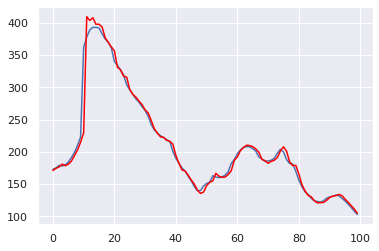

In [277]:
error = mean_squared_error(testsingle, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(testsingle[:100])
pyplot.plot(predictions[:100], color='red')
pyplot.show()

In [278]:
from math import sqrt
rmse = sqrt(error)
print('RMSE: %f' % rmse)

RMSE: 5.702748


## Performance Evaluation

Future steps: 

Since the datapoints are spaced out 5 minutes apart, and I wish to predict glucose levels up to an hour from the present moment, I can use a forecast method with 12 steps (5 minutes * 12 steps = 60 minutes). That will give the real-world predictions we are interested in, and the future (MARD and Clarke Error Grid A and A+B zone percentages ) metrics will be based on those results. The MA, AR and AR_11 models can then be compared based on those metrics, and the best one selected.

Furthermore, in order to take the heart rate and activity data into account, a multivariable model with multiple inputs would need to be constructed. An LSTM model, combining linear and nonlinear algorithms, would be suitable for this task.

In [279]:
model_ar = ARIMA(df_bgtrain.bg_level, order = (1,0,0))
results_ar = model_ar.fit()

In [280]:
df_bgtrain.bg_level.tail()

point_timestamp
2017-06-17 20:57:22    152.0
2017-06-17 20:58:22    152.0
2017-06-17 20:59:22    152.0
2017-06-17 21:00:22    152.0
2017-06-17 21:01:22    152.0
Freq: T, Name: bg_level, dtype: float64

In [281]:
# create variables that will help us change the periods easily instead of typing them up every time
# make sure the start and end dates are business days, otherwise the code will result in an error

start_date = '2017-06-17 21:02:22'
end_date = '2017-07-15 07:49:22'

In [282]:
end_date = "2019-10-23"
df_pred = results_ar.predict(start = start_date, end = end_date)

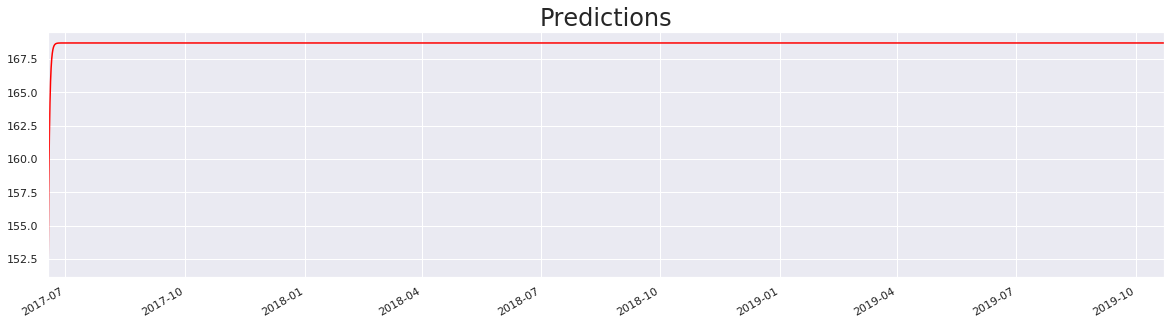

In [283]:
df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
plt.title("Predictions", size = 24)
plt.show()

In [284]:
end_date = '2017-07-15 07:49:22'
df_pred = results_ar.predict(start = start_date, end = end_date)

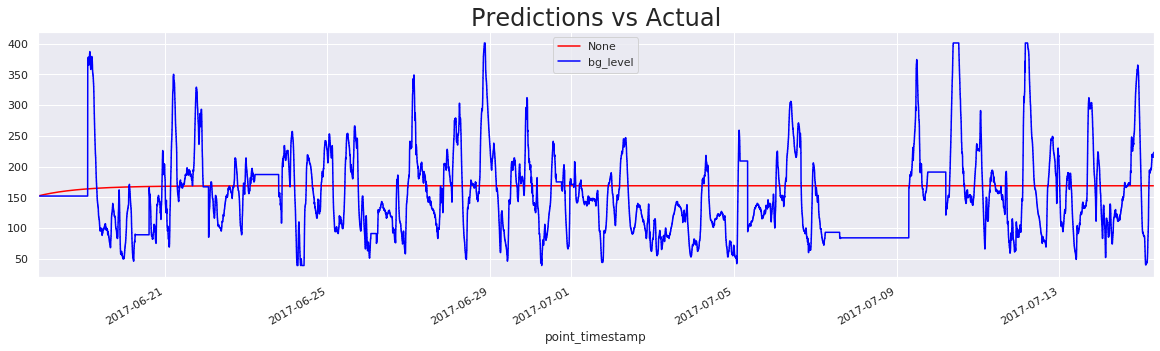

In [285]:
df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_bgtest.bg_level[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.legend()
plt.show()